In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ==== Cài đặt các thư viện cần thiết ====
!pip install ultralytics --quiet
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install git+https://github.com/huggingface/peft.git
!pip install transformers accelerate
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install opencv-python pillow scikit-learn matplotlib tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.3 MB/s eta 0:00:00
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-y87aflpd
  Running command git cl

In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -P /content/


--2025-06-19 10:55:48--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.173.166.51, 18.173.166.74, 18.173.166.31, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.173.166.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘/content/sam_vit_b_01ec64.pth’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M   154MB/s    in 2.3s    

2025-06-19 10:55:50 (154 MB/s) - ‘/content/sam_vit_b_01ec64.pth’ saved [375042383/375042383]



In [ ]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.down1 = DoubleConv(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        d3 = self.down3(self.pool2(d2))
        d4 = self.down4(self.pool3(d3))

        bn = self.bottleneck(self.pool4(d4))

        x = self.up4(bn)
        x = self.conv4(torch.cat([x, d4], dim=1))
        x = self.up3(x)
        x = self.conv3(torch.cat([x, d3], dim=1))
        x = self.up2(x)
        x = self.conv2(torch.cat([x, d2], dim=1))
        x = self.up1(x)
        x = self.conv1(torch.cat([x, d1], dim=1))
        return torch.sigmoid(self.final(x))


In [ ]:
import os
import gc
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamPredictor
from peft import PeftModel
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ==== Load YOLOv8 ====
yolo_model = YOLO("/content/drive/MyDrive/Extracted_MRI/runs/detect/train/weights/best.pt")

# ==== Load SAM + LoRA ====
SAM_CHECKPOINT = "/content/sam_vit_b_01ec64.pth"
LORA_PATH = "/content/drive/MyDrive/fine_tune_data/sam_lora_with_imgenc"

sam_base = sam_model_registry["vit_b"](checkpoint=SAM_CHECKPOINT).to(DEVICE)
sam_base.eval()
sam_lora = PeftModel.from_pretrained(sam_base, LORA_PATH)
sam_lora.eval()

# ==== Load U-Net ====
unet = UNet().to(DEVICE)
unet.load_state_dict(torch.load("/content/drive/MyDrive/unet_mri_best.pth", map_location=DEVICE))
unet.eval()

# ==== Crop ảnh có mở rộng bbox ====
def crop_tumor_from_yolo(image_path, expand_ratio=0.2):
    image = cv2.imread(image_path)
    H, W = image.shape[:2]
    results = yolo_model.predict(image)[0]
    crops, bboxes = [], []

    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        w, h = x2 - x1, y2 - y1
        dw, dh = int(w * expand_ratio), int(h * expand_ratio)
        x1n = max(x1 - dw, 0)
        y1n = max(y1 - dh, 0)
        x2n = min(x2 + dw, W)
        y2n = min(y2 + dh, H)
        crops.append(image[y1n:y2n, x1n:x2n])
        bboxes.append((x1n, y1n, x2n, y2n))
    return crops, bboxes, results, image

# ==== Dự đoán mask từ SAM+LoRA bằng box ====
def predict_mask_sam(image_np, model):
    predictor = SamPredictor(model)
    predictor.set_image(image_np.astype(np.uint8))
    input_box = np.array([0, 0, image_np.shape[1], image_np.shape[0]])  # toàn ảnh
    masks, _, _ = predictor.predict(box=input_box[None, :], multimask_output=False)
    return masks[0].astype(np.uint8)

# ==== Dự đoán mask từ U-Net ====
def predict_mask_unet(image_pil):
    transform = T.Compose([T.Resize((256, 256)), T.ToTensor()])
    input_tensor = transform(image_pil).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        output = unet(input_tensor)
    mask = output.squeeze().cpu().numpy()
    return (mask > 0.5).astype(np.uint8)

# ==== Kết hợp 2 mask ====
def combine_masks(mask1, mask2, alpha=0.5):
    return ((alpha * mask1 + (1 - alpha) * mask2) > 0.5).astype(np.uint8)

# ==== Tỉ lệ pixel khối u trong ảnh ====
def tumor_pixel_ratio(mask):
    return np.sum(mask > 0) / mask.size

# ==== IoU giữa 2 mask ====
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / (union + 1e-6)

# ==== Tỉ lệ khối u trên ảnh gốc ====
def tumor_pixel_ratio_global(mask_crop, bbox, image_shape):
    x1, y1, x2, y2 = map(int, bbox)
    H, W = image_shape[:2]
    mask_resized = cv2.resize(mask_crop, (x2 - x1, y2 - y1), interpolation=cv2.INTER_NEAREST)
    full_mask = np.zeros((H, W), dtype=np.uint8)
    full_mask[y1:y2, x1:x2] = mask_resized
    return np.sum(full_mask > 0) / (H * W)

# ==== Pipeline chính ====
def full_pipeline(image_path, alpha=0.5, expand_ratio=0.2, save_dir="results_masks"):
    os.makedirs(save_dir, exist_ok=True)
    crops, bboxes, results, original_image = crop_tumor_from_yolo(image_path, expand_ratio)

    if not crops:
        print(f"❌ Không phát hiện khối u trong ảnh: {image_path}")
        return

    for i, (crop, bbox) in enumerate(zip(crops, bboxes)):
        crop_resized = cv2.resize(crop, (256, 256), interpolation=cv2.INTER_LINEAR)
        crop_pil = Image.fromarray(cv2.cvtColor(crop_resized, cv2.COLOR_BGR2RGB))
        crop_np = np.array(crop_pil)

        # Dự đoán mask
        mask_sam = predict_mask_sam(crop_np, sam_lora)
        mask_unet = predict_mask_unet(crop_pil)
        mask_combined = combine_masks(mask_sam, mask_unet, alpha=alpha)

        # Chỉ số đánh giá
        ratio_crop = tumor_pixel_ratio(mask_combined)
        ratio_global = tumor_pixel_ratio_global(mask_combined, bbox, original_image.shape)
        iou = compute_iou(mask_sam, mask_unet)

        # Hiển thị kết quả
        fig, axs = plt.subplots(1, 4, figsize=(18, 4))
        axs[0].imshow(crop_pil)
        axs[0].set_title("Ảnh Crop")
        axs[1].imshow(mask_sam, cmap="gray")
        axs[1].set_title("Mask SAM+LoRA")
        axs[2].imshow(mask_unet, cmap="gray")
        axs[2].set_title("Mask U-Net")
        axs[3].imshow(mask_combined, cmap="gray")
        axs[3].set_title(f"Kết hợp (α={alpha})\nIoU: {iou:.2f}\nCrop: {ratio_crop:.2%}\nGốc: {ratio_global:.2%}")
        for ax in axs: ax.axis("off")
        plt.tight_layout()
        plt.show()

        # Lưu kết quả
        save_path = os.path.join(save_dir, f"mask_combined_{i}.png")
        cv2.imwrite(save_path, (mask_combined * 255).astype(np.uint8))
        print(f"✅ Đã lưu mask tại: {save_path}")

        # Giải phóng bộ nhớ
        gc.collect()
        torch.cuda.empty_cache()



0: 640x608 1 Meningioma, 41.2ms
Speed: 10.5ms preprocess, 41.2ms inference, 263.4ms postprocess per image at shape (1, 3, 640, 608)


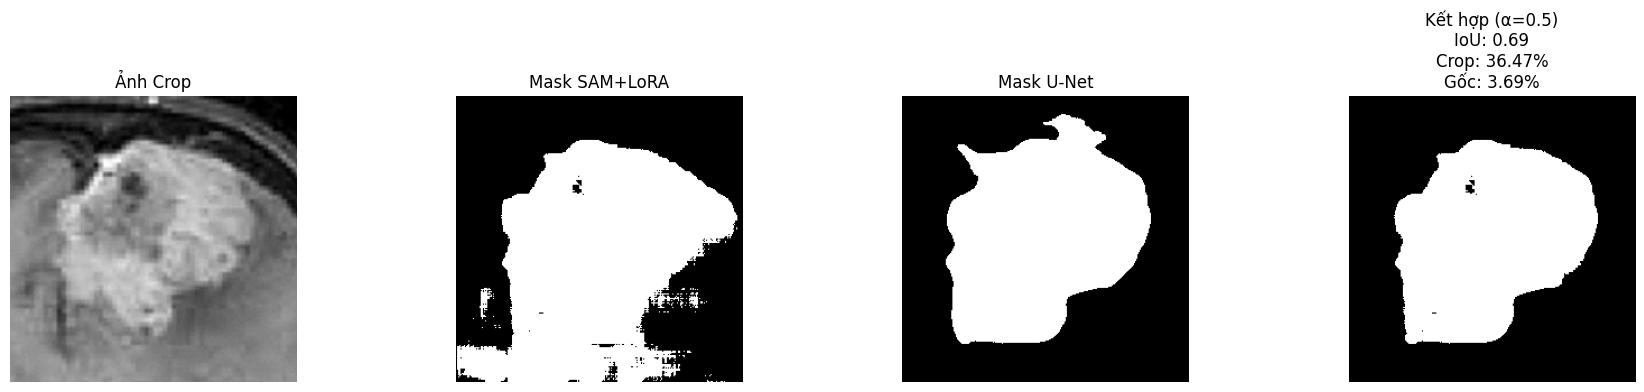

✅ Đã lưu mask tại: results_masks/mask_combined_0.png


In [ ]:
full_pipeline("/content/tumor_test.png", alpha=0.5)


In [ ]:
import os
import gc
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
from segment_anything import SamPredictor
from ultralytics import YOLO

# ==== Hàm crop ảnh từ YOLO (mở rộng bbox thêm 20%) ====
def crop_tumor_from_yolo(image_path, expand_ratio=0.2):
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    H, W = image.shape[:2]
    results = yolo_model.predict(image)[0]
    crops, bboxes = [], []

    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        w, h = x2 - x1, y2 - y1
        dw, dh = int(w * expand_ratio), int(h * expand_ratio)
        x1_new = max(x1 - dw, 0)
        y1_new = max(y1 - dh, 0)
        x2_new = min(x2 + dw, W)
        y2_new = min(y2 + dh, H)

        crop = image[y1_new:y2_new, x1_new:x2_new]
        crops.append(crop)
        bboxes.append((x1_new, y1_new, x2_new, y2_new))

    return crops, bboxes, results, image

# ==== Dự đoán mask bằng SAM (dùng bbox) ====
def predict_mask_sam(image_np, model):
    predictor = SamPredictor(model)
    predictor.set_image(image_np.astype(np.uint8))
    input_box = np.array([0, 0, image_np.shape[1], image_np.shape[0]])  # box full ảnh crop
    masks, _, _ = predictor.predict(box=input_box[None, :], multimask_output=False)
    return masks[0].astype(np.uint8)

# ==== Dự đoán mask từ UNet ====
def predict_mask_unet(image_pil):
    transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor()
    ])
    input_tensor = transform(image_pil).unsqueeze(0).to(DEVICE)
    with torch.inference_mode():
        output = unet(input_tensor)
    mask = output.squeeze().cpu().numpy()
    return (mask > 0.5).astype(np.uint8)

# ==== Kết hợp mask ====
def combine_masks(mask1, mask2, alpha=0.5):
    return ((alpha * mask1 + (1 - alpha) * mask2) > 0.5).astype(np.uint8)

# ==== Tỉ lệ pixel khối u ====
def tumor_pixel_ratio(mask):
    return np.sum(mask > 0) / mask.size

# ==== IoU giữa hai mask ====
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / (union + 1e-6)

# ==== Pipeline tổng hợp ====
def full_pipeline(image_path, alpha=0.5, expand_ratio=0.2, save_dir="results_masks"):
    os.makedirs(save_dir, exist_ok=True)
    crops, bboxes, results, original_image = crop_tumor_from_yolo(image_path, expand_ratio)

    if not crops:
        print(f"❌ Không phát hiện khối u trong ảnh: {image_path}")
        return

    for i, (crop, (x1, y1, x2, y2)) in enumerate(zip(crops, bboxes)):
        crop_resized = cv2.resize(crop, (256, 256), interpolation=cv2.INTER_LINEAR)
        crop_pil = Image.fromarray(crop_resized)
        crop_np = np.array(crop_pil)

        # Dự đoán mask
        mask_sam = predict_mask_sam(crop_np, sam_lora)
        mask_unet = predict_mask_unet(crop_pil)
        mask_combined = combine_masks(mask_sam, mask_unet, alpha=alpha)

        # Resize mask kết hợp về bbox
        mask_orig_size = cv2.resize(mask_combined, (x2 - x1, y2 - y1), interpolation=cv2.INTER_NEAREST)
        full_mask = np.zeros(original_image.shape[:2], dtype=np.uint8)
        full_mask[y1:y2, x1:x2] = mask_orig_size

        # Tính toán
        ratio_crop = tumor_pixel_ratio(mask_combined)
        ratio_full = tumor_pixel_ratio(full_mask)
        iou = compute_iou(mask_sam, mask_unet)

        # Hiển thị kết quả
        fig, axs = plt.subplots(1, 5, figsize=(20, 4))
        axs[0].imshow(crop_pil)
        axs[0].set_title("Ảnh Crop")
        axs[1].imshow(mask_sam, cmap="gray")
        axs[1].set_title("Mask SAM+LoRA")
        axs[2].imshow(mask_unet, cmap="gray")
        axs[2].set_title("Mask U-Net")
        axs[3].imshow(mask_combined, cmap="gray")
        axs[3].set_title(f"Kết hợp (α={alpha})\nIoU: {iou:.2f}\nCrop: {ratio_crop:.2%}")
        axs[4].imshow(full_mask, cmap="gray")
        axs[4].set_title(f"Trên ảnh gốc\nTỉ lệ: {ratio_full:.2%}")
        for ax in axs: ax.axis("off")
        plt.tight_layout()
        plt.show()

        # Lưu mask
        save_path = os.path.join(save_dir, f"mask_combined_{i}.png")
        cv2.imwrite(save_path, (full_mask * 255).astype(np.uint8))
        print(f"✅ Đã lưu mask đầy đủ tại: {save_path}")

        # Giải phóng bộ nhớ
        gc.collect()
        torch.cuda.empty_cache()



0: 640x608 1 Meningioma, 16.9ms
Speed: 3.4ms preprocess, 16.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 608)


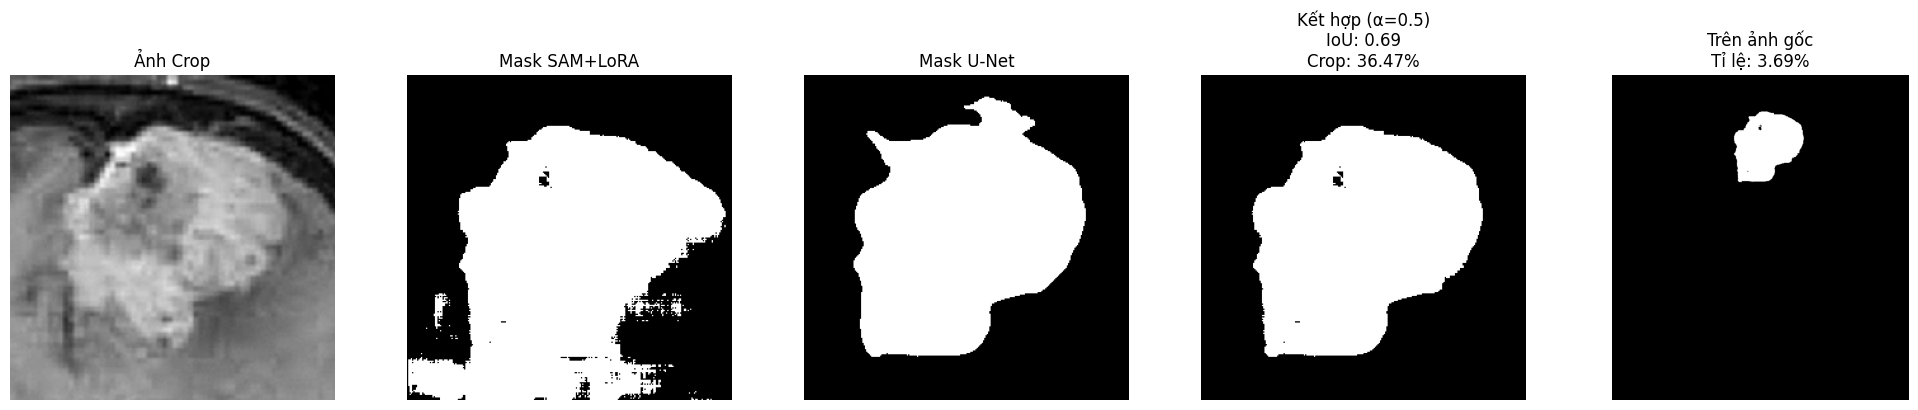

✅ Đã lưu mask đầy đủ tại: results_masks/mask_combined_0.png


In [ ]:
full_pipeline("/content/tumor_test.png", alpha=0.5, expand_ratio=0.2)


In [ ]:
import os
import gc
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
from segment_anything import SamPredictor
from ultralytics import YOLO

# ==== Hàm crop ảnh từ YOLO (mở rộng bbox thêm 20%) ====
def crop_tumor_from_yolo(image_path, expand_ratio=0.2):
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    H, W = image.shape[:2]
    results = yolo_model.predict(image)[0]
    crops, bboxes = [], []

    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        w, h = x2 - x1, y2 - y1
        dw, dh = int(w * expand_ratio), int(h * expand_ratio)
        x1_new = max(x1 - dw, 0)
        y1_new = max(y1 - dh, 0)
        x2_new = min(x2 + dw, W)
        y2_new = min(y2 + dh, H)

        crop = image[y1_new:y2_new, x1_new:x2_new]
        crops.append(crop)
        bboxes.append((x1_new, y1_new, x2_new, y2_new))

    return crops, bboxes, results, image

# ==== Dự đoán mask bằng SAM (dùng bbox toàn ảnh) ====
def predict_mask_sam(image_np, model):
    predictor = SamPredictor(model)
    predictor.set_image(image_np.astype(np.uint8))
    input_box = np.array([0, 0, image_np.shape[1], image_np.shape[0]])  # box full ảnh crop
    masks, _, _ = predictor.predict(box=input_box[None, :], multimask_output=False)
    return masks[0].astype(np.uint8)

# ==== Dự đoán mask từ UNet ====
def predict_mask_unet(image_pil):
    transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor()
    ])
    input_tensor = transform(image_pil).unsqueeze(0).to(DEVICE)
    with torch.inference_mode():
        output = unet(input_tensor)
    mask = output.squeeze().cpu().numpy()
    return (mask > 0.5).astype(np.uint8)

# ==== Kết hợp mask ====
def combine_masks(mask1, mask2, alpha=0.5):
    return ((alpha * mask1 + (1 - alpha) * mask2) > 0.5).astype(np.uint8)

# ==== Tỉ lệ pixel khối u ====
def tumor_pixel_ratio(mask):
    return np.sum(mask > 0) / mask.size

# ==== IoU giữa hai mask ====
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / (union + 1e-6)

# ==== Pipeline tổng hợp ====
def full_pipeline(image_path, alpha=0.5, expand_ratio=0.2, save_dir="results_masks"):
    os.makedirs(save_dir, exist_ok=True)
    crops, bboxes, results, original_image = crop_tumor_from_yolo(image_path, expand_ratio)

    if not crops:
        print(f"❌ Không phát hiện khối u trong ảnh: {image_path}")
        return

    for i, (crop, (x1, y1, x2, y2)) in enumerate(zip(crops, bboxes)):
        crop_resized = cv2.resize(crop, (256, 256), interpolation=cv2.INTER_LINEAR)
        crop_pil = Image.fromarray(crop_resized)
        crop_np = np.array(crop_pil)

        # Dự đoán mask
        mask_sam = predict_mask_sam(crop_np, sam_lora)
        mask_unet = predict_mask_unet(crop_pil)
        mask_combined = combine_masks(mask_sam, mask_unet, alpha=alpha)

        # Resize mask kết hợp về bbox
        mask_orig_size = cv2.resize(mask_combined, (x2 - x1, y2 - y1), interpolation=cv2.INTER_NEAREST)
        full_mask = np.zeros(original_image.shape[:2], dtype=np.uint8)
        full_mask[y1:y2, x1:x2] = mask_orig_size

        # Tính toán thống kê
        ratio_crop = tumor_pixel_ratio(mask_combined)
        ratio_full = tumor_pixel_ratio(full_mask)
        iou = compute_iou(mask_sam, mask_unet)

        # Hiển thị kết quả
        fig, axs = plt.subplots(1, 5, figsize=(20, 4))
        axs[0].imshow(crop_pil)
        axs[0].set_title("Ảnh Crop")
        axs[1].imshow(mask_sam, cmap="gray")
        axs[1].set_title("Mask SAM+LoRA")
        axs[2].imshow(mask_unet, cmap="gray")
        axs[2].set_title("Mask U-Net")
        axs[3].imshow(mask_combined, cmap="gray")
        axs[3].set_title(f"Kết hợp (α={alpha})\nIoU: {iou:.2f}\nCrop: {ratio_crop:.2%}")
        axs[4].imshow(full_mask, cmap="gray")
        axs[4].set_title(f"Trên ảnh gốc\nTỉ lệ: {ratio_full:.2%}")
        for ax in axs: ax.axis("off")
        plt.tight_layout()
        plt.show()

        # Lưu mask
        save_path = os.path.join(save_dir, f"mask_combined_{i}.png")
        cv2.imwrite(save_path, (full_mask * 255).astype(np.uint8))
        print(f"✅ Đã lưu mask đầy đủ tại: {save_path}")

        # Giải phóng bộ nhớ
        gc.collect()
        torch.cuda.empty_cache()



0: 640x608 1 Meningioma, 16.9ms
Speed: 3.2ms preprocess, 16.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 608)


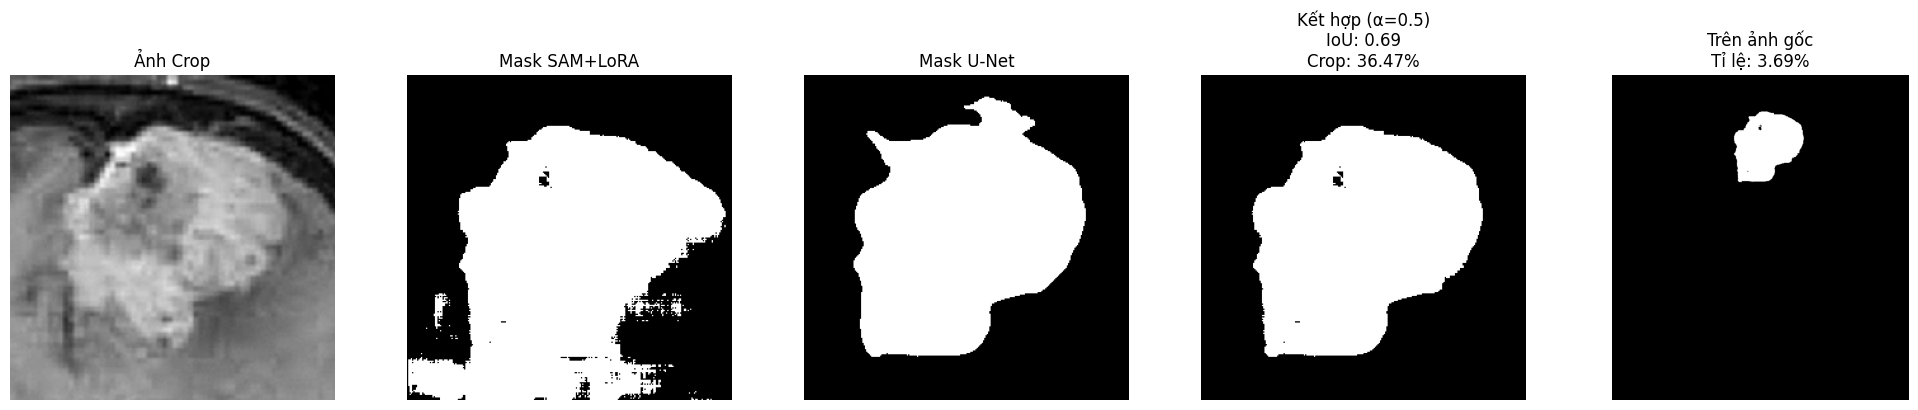

✅ Đã lưu mask đầy đủ tại: results_masks/mask_combined_0.png


In [ ]:
full_pipeline("/content/tumor_test.png", alpha=0.5)



0: 640x640 1 Meningioma, 18.0ms
Speed: 3.7ms preprocess, 18.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


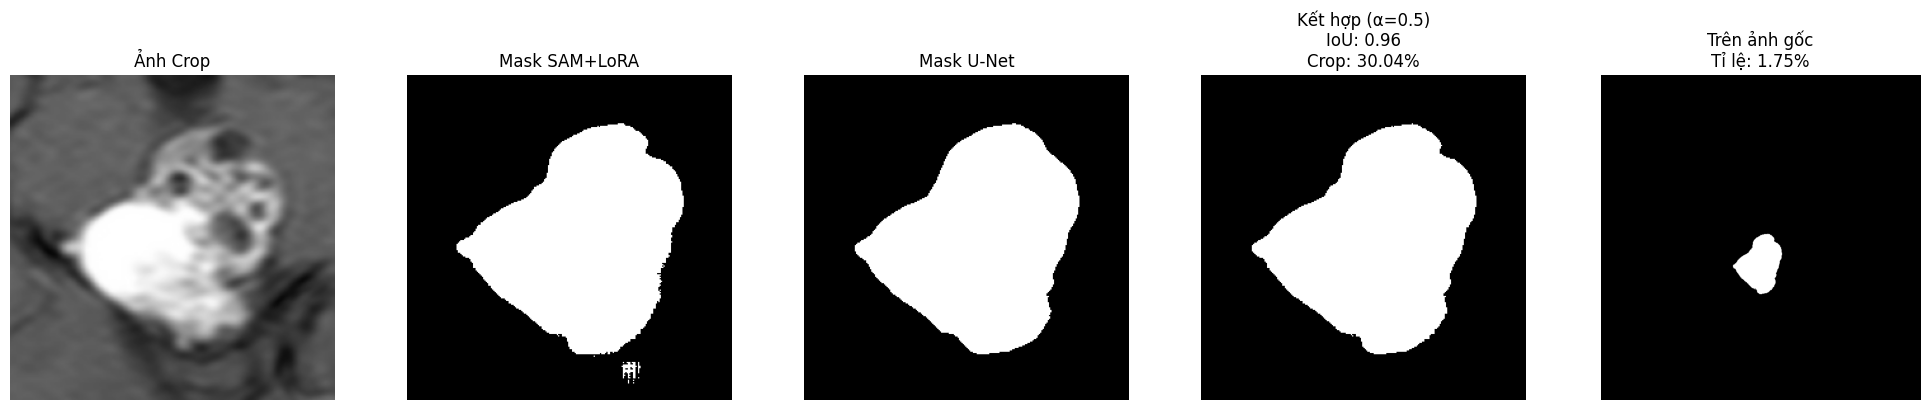

✅ Đã lưu mask đầy đủ tại: results_masks/mask_combined_0.png


In [ ]:
full_pipeline("/content/tumor_test1.png", alpha=0.5)


0: 640x608 1 Glioma, 1 Meningioma, 17.6ms
Speed: 2.7ms preprocess, 17.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 608)


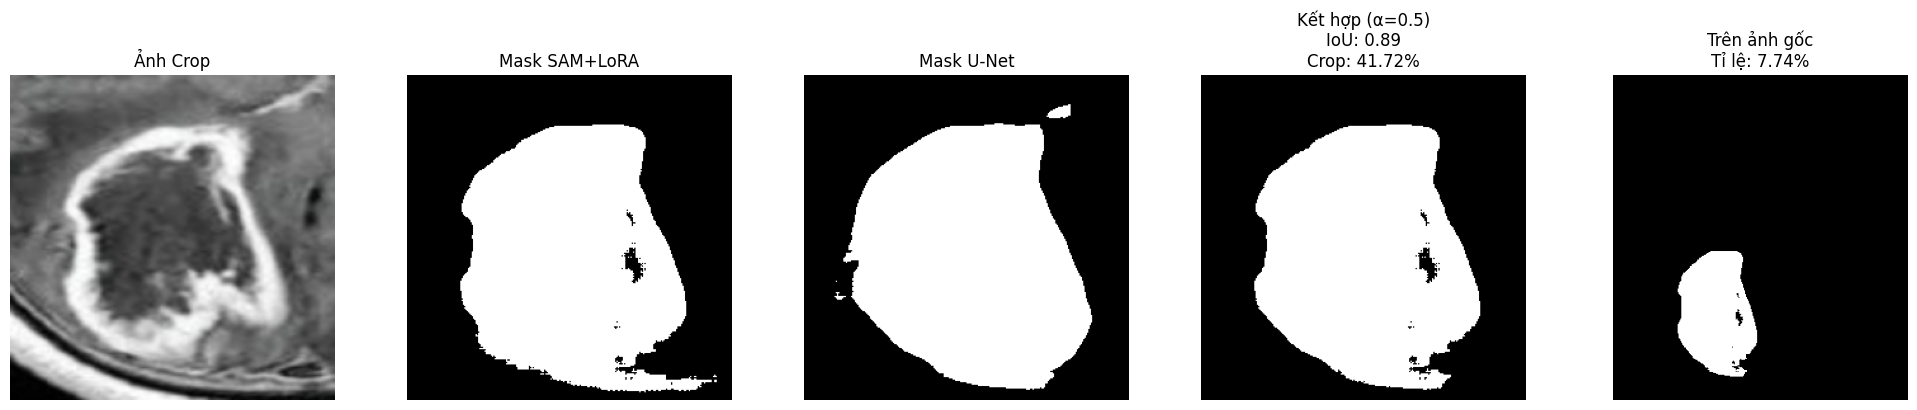

✅ Đã lưu mask đầy đủ tại: results_masks/mask_combined_0.png


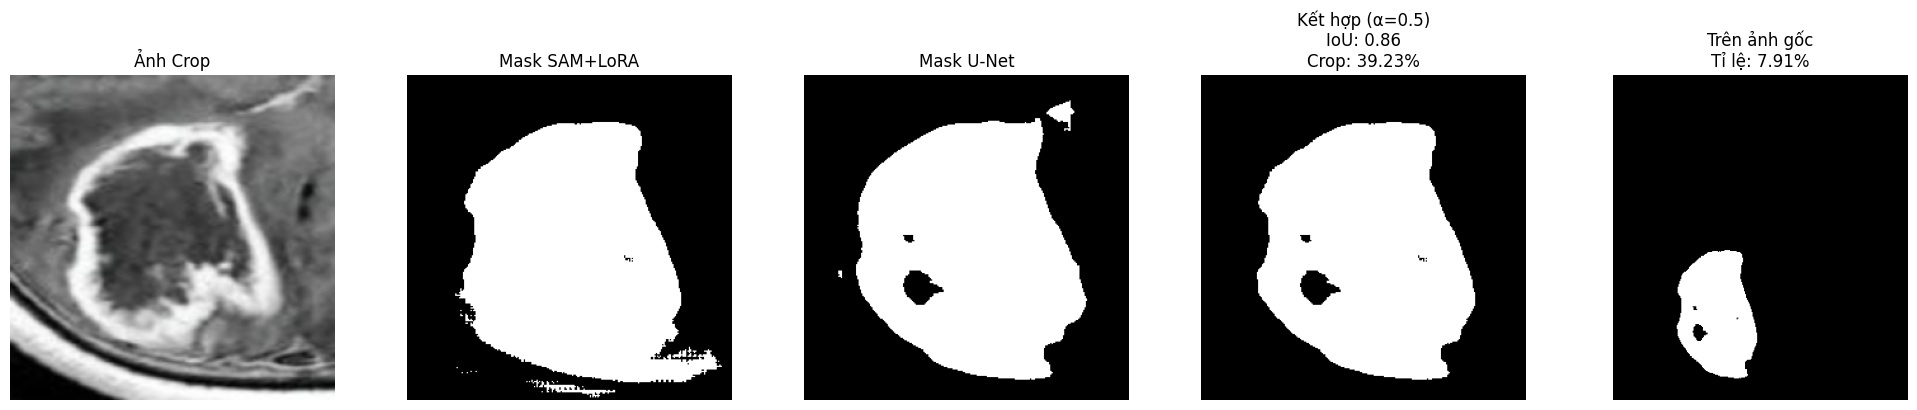

✅ Đã lưu mask đầy đủ tại: results_masks/mask_combined_1.png


In [ ]:
full_pipeline("/content/tumor_test3.png", alpha=0.5)


0: 640x640 2 Meningiomas, 19.0ms
Speed: 2.9ms preprocess, 19.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


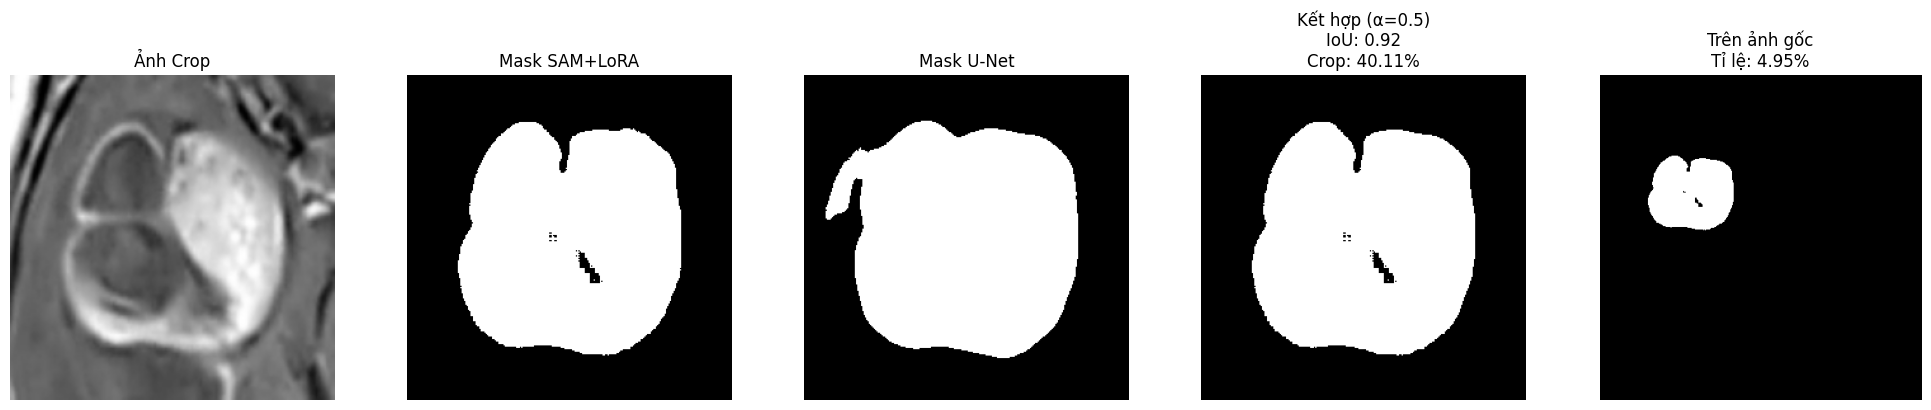

✅ Đã lưu mask đầy đủ tại: results_masks/mask_combined_0.png


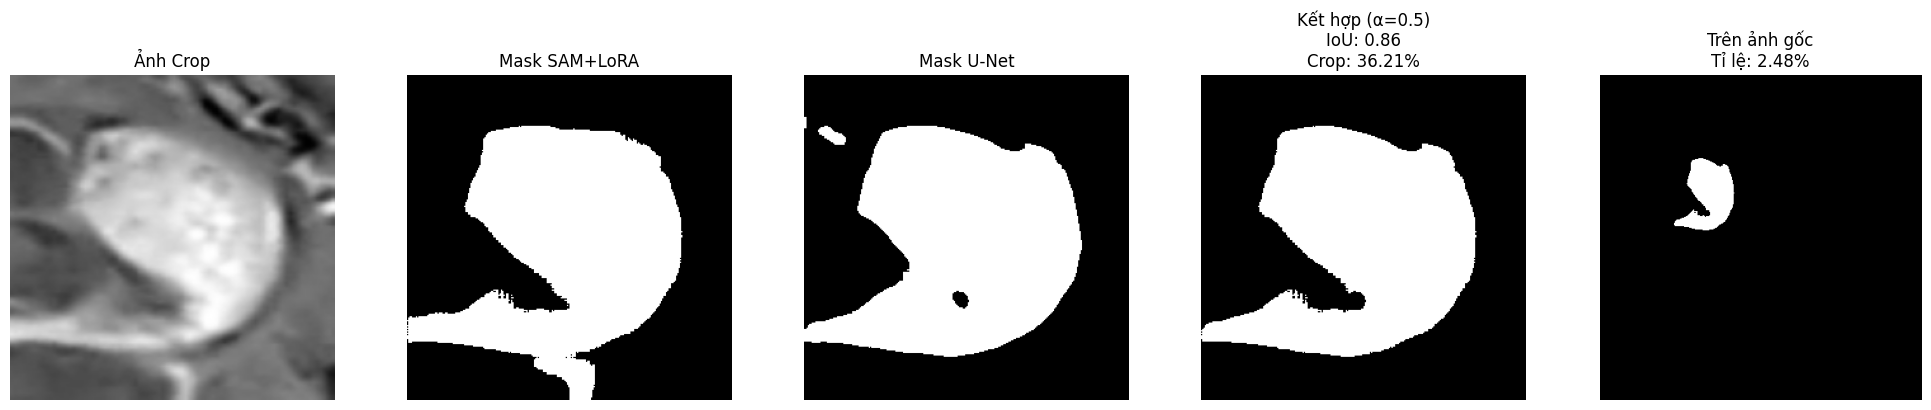

✅ Đã lưu mask đầy đủ tại: results_masks/mask_combined_1.png


In [ ]:
full_pipeline("/content/tumor_test4.png", alpha=0.5)

In [ ]:
full_pipeline("/content/tumor_test5.png", alpha=0.5)


0: 640x576 (no detections), 43.8ms
Speed: 2.9ms preprocess, 43.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)
❌ Không phát hiện khối u trong ảnh: /content/tumor_test5.png



0: 640x544 1 Meningioma, 42.0ms
Speed: 5.3ms preprocess, 42.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


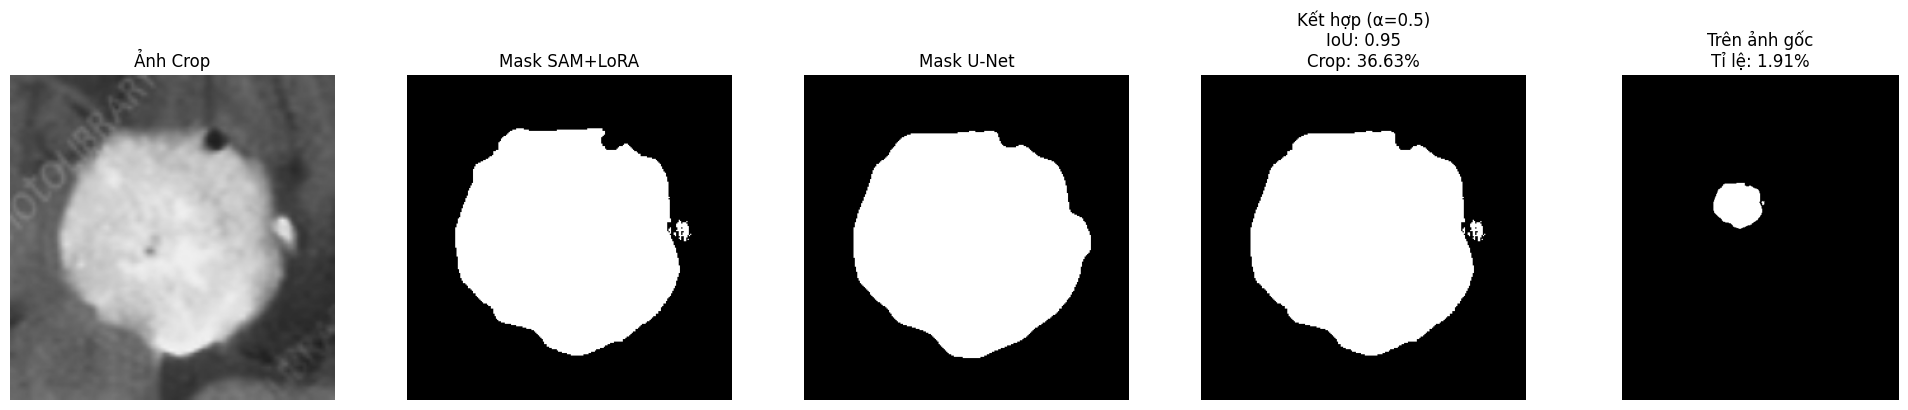

✅ Đã lưu mask đầy đủ tại: results_masks/mask_combined_0.png


In [ ]:
full_pipeline("/content/tumor_test6.png", alpha=0.5)

In [ ]:
import os
import gc
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
from segment_anything import SamPredictor
from ultralytics import YOLO

# ==== Hàm crop ảnh từ YOLO (mở rộng bbox thêm 20%) ====
def crop_tumor_from_yolo(image_path, expand_ratio=0.2):
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    H, W = image.shape[:2]
    results = yolo_model.predict(image)[0]
    crops, bboxes = [], []

    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        w, h = x2 - x1, y2 - y1
        dw, dh = int(w * expand_ratio), int(h * expand_ratio)
        x1_new = max(x1 - dw, 0)
        y1_new = max(y1 - dh, 0)
        x2_new = min(x2 + dw, W)
        y2_new = min(y2 + dh, H)

        crop = image[y1_new:y2_new, x1_new:x2_new]
        crops.append(crop)
        bboxes.append((x1_new, y1_new, x2_new, y2_new))

    return crops, bboxes, results, image

# ==== Dự đoán mask bằng SAM (dùng bbox toàn ảnh) ====
def predict_mask_sam(image_np, model):
    predictor = SamPredictor(model)
    predictor.set_image(image_np.astype(np.uint8))
    input_box = np.array([0, 0, image_np.shape[1], image_np.shape[0]])  # box full ảnh crop
    masks, _, _ = predictor.predict(box=input_box[None, :], multimask_output=False)
    return masks[0].astype(np.uint8)

# ==== Dự đoán mask từ UNet ====
def predict_mask_unet(image_pil):
    transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor()
    ])
    input_tensor = transform(image_pil).unsqueeze(0).to(DEVICE)
    with torch.inference_mode():
        output = unet(input_tensor)
    mask = output.squeeze().cpu().numpy()
    return (mask > 0.5).astype(np.uint8)

# ==== Kết hợp mask ====
def combine_masks(mask1, mask2, method='avg', alpha=0.5):
    if method == 'avg':
        return ((alpha * mask1 + (1 - alpha) * mask2) > 0.5).astype(np.uint8)
    elif method == 'and':
        return np.logical_and(mask1, mask2).astype(np.uint8)
    elif method == 'or':
        return np.logical_or(mask1, mask2).astype(np.uint8)
    else:
        raise ValueError(f"Phương pháp kết hợp không hợp lệ: {method}")


# ==== Tỉ lệ pixel khối u ====
def tumor_pixel_ratio(mask):
    return np.sum(mask > 0) / mask.size

# ==== IoU giữa hai mask ====
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / (union + 1e-6)

# ==== Pipeline tổng hợp ====
def full_pipeline_compare_methods(image_path, expand_ratio=0.2):
    crops, bboxes, results, original_image = crop_tumor_from_yolo(image_path, expand_ratio)

    if not crops:
        print(f"❌ Không phát hiện khối u trong ảnh: {image_path}")
        return

    for i, (crop, (x1, y1, x2, y2)) in enumerate(zip(crops, bboxes)):
        crop_resized = cv2.resize(crop, (256, 256), interpolation=cv2.INTER_LINEAR)
        crop_pil = Image.fromarray(crop_resized)
        crop_np = np.array(crop_pil)

        # Dự đoán mask
        mask_sam = predict_mask_sam(crop_np, sam_lora)
        mask_unet = predict_mask_unet(crop_pil)

        # Các phương pháp kết hợp
        methods = [
            ("avg", 0.5),  # dòng 1
            ("avg", 0.3),  # dòng 2
            ("avg", 0.7),  # dòng 2
            ("and", None), # dòng 2
            ("or", None),  # dòng 2
        ]

        fig, axs = plt.subplots(2, 4, figsize=(20, 10))

        # ==== Dòng 1 ====
        axs[0, 0].imshow(crop_pil)
        axs[0, 0].set_title("Ảnh Crop", fontsize=14)

        axs[0, 1].imshow(mask_sam, cmap="gray")
        axs[0, 1].set_title("Mask SAM+LoRA", fontsize=12)

        axs[0, 2].imshow(mask_unet, cmap="gray")
        axs[0, 2].set_title("Mask U-Net", fontsize=12)

        method, alpha = methods[0]
        mask_avg05 = combine_masks(mask_sam, mask_unet, method=method, alpha=alpha)
        axs[0, 3].imshow(mask_avg05, cmap="gray")
        axs[0, 3].set_title(f"{method.upper()} (α={alpha})", fontsize=12)

        # ==== Dòng 2 ====
        for idx, (method, alpha) in enumerate(methods[1:]):
            mask_combined = combine_masks(mask_sam, mask_unet, method=method, alpha=alpha or 0.5)
            title = f"{method.upper()}" if alpha is None else f"{method.upper()} (α={alpha})"
            axs[1, idx].imshow(mask_combined, cmap="gray")
            axs[1, idx].set_title(title, fontsize=12)

        # Ẩn khung rỗng nếu có
        for r in range(2):
            for c in range(4):
                axs[r, c].axis("off") if axs[r, c].images == [] else axs[r, c].axis("off")

        plt.tight_layout()
        plt.show()


In [ ]:
def run_random_image_test(img_dir):
    import random, os

    # Lấy danh sách ảnh
    img_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Chọn ảnh ngẫu nhiên mỗi lần gọi
    random_img_path = os.path.join(img_dir, random.choice(img_files))
    print("🖼️ Ảnh được chọn:", random_img_path)

    # Chạy pipeline
    full_pipeline_compare_methods(random_img_path)


🖼️ Ảnh được chọn: /content/drive/MyDrive/Extracted_MRI/Val/Glioma/images/gg (135).jpg

0: 640x640 3 Gliomas, 16.3ms
Speed: 3.0ms preprocess, 16.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


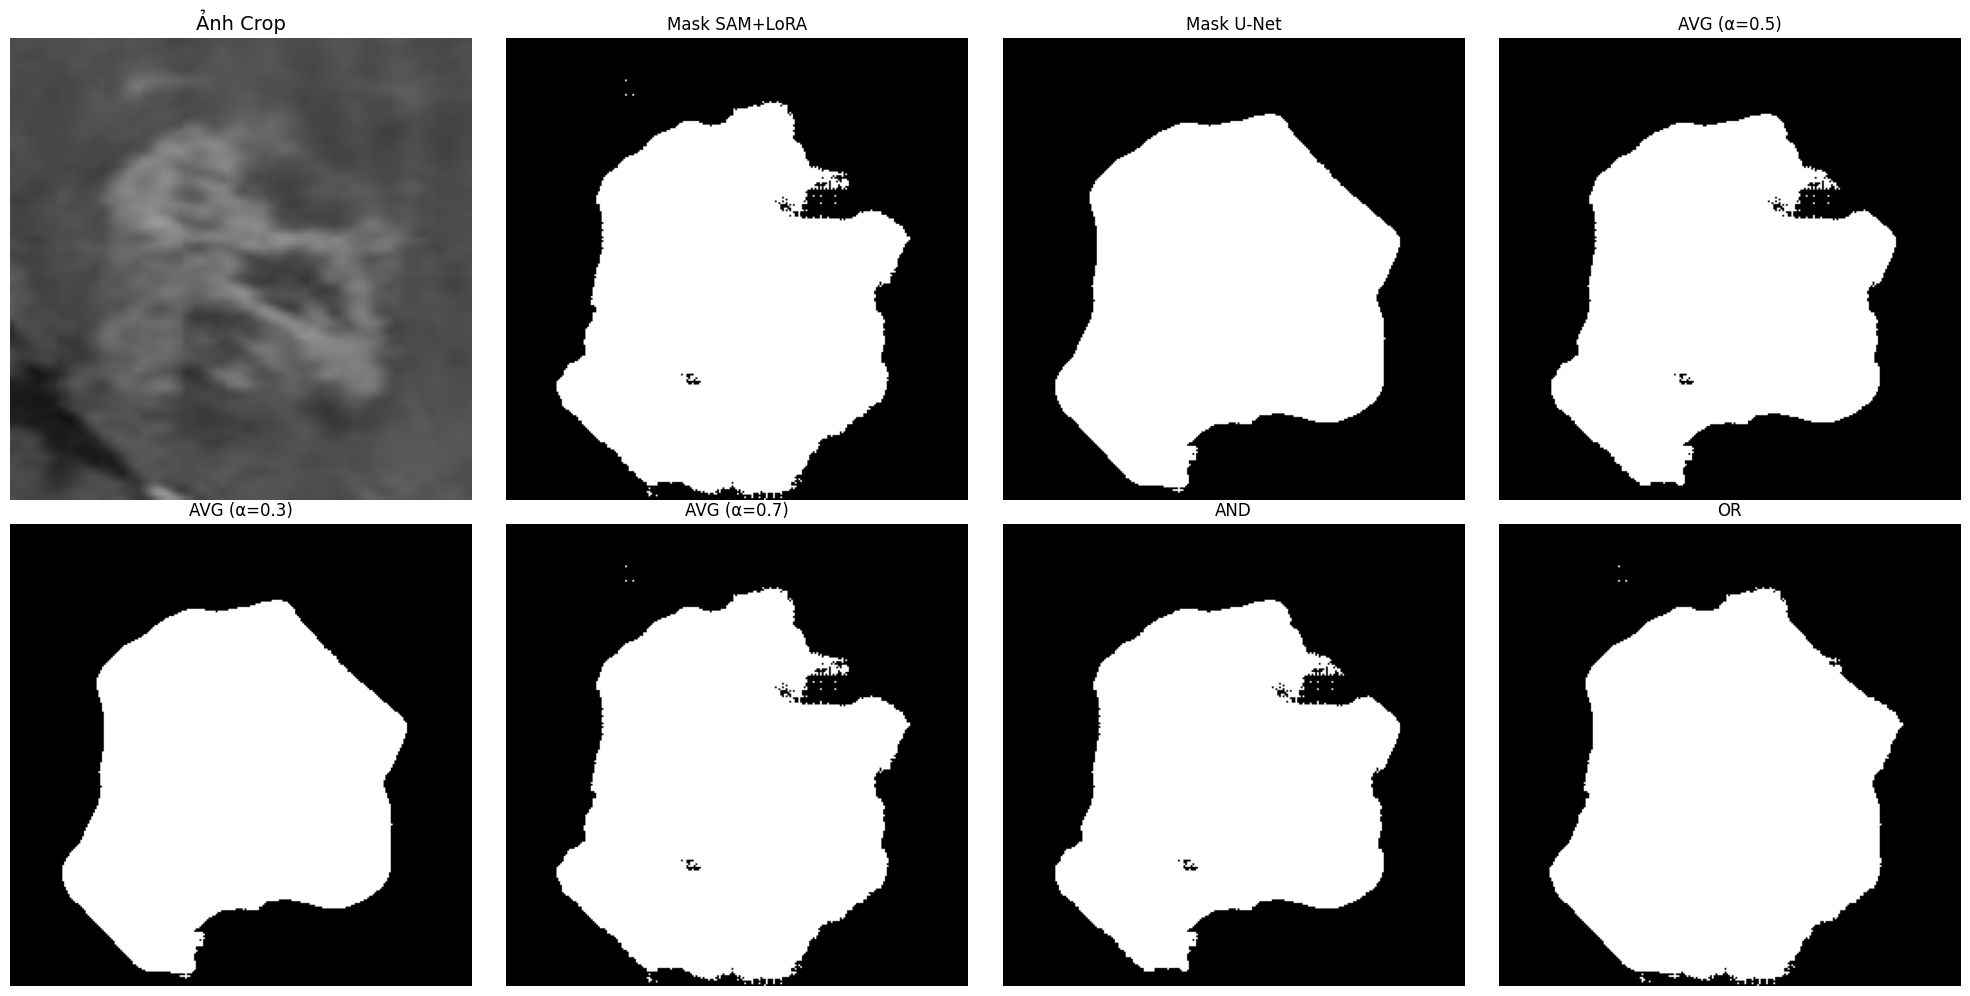

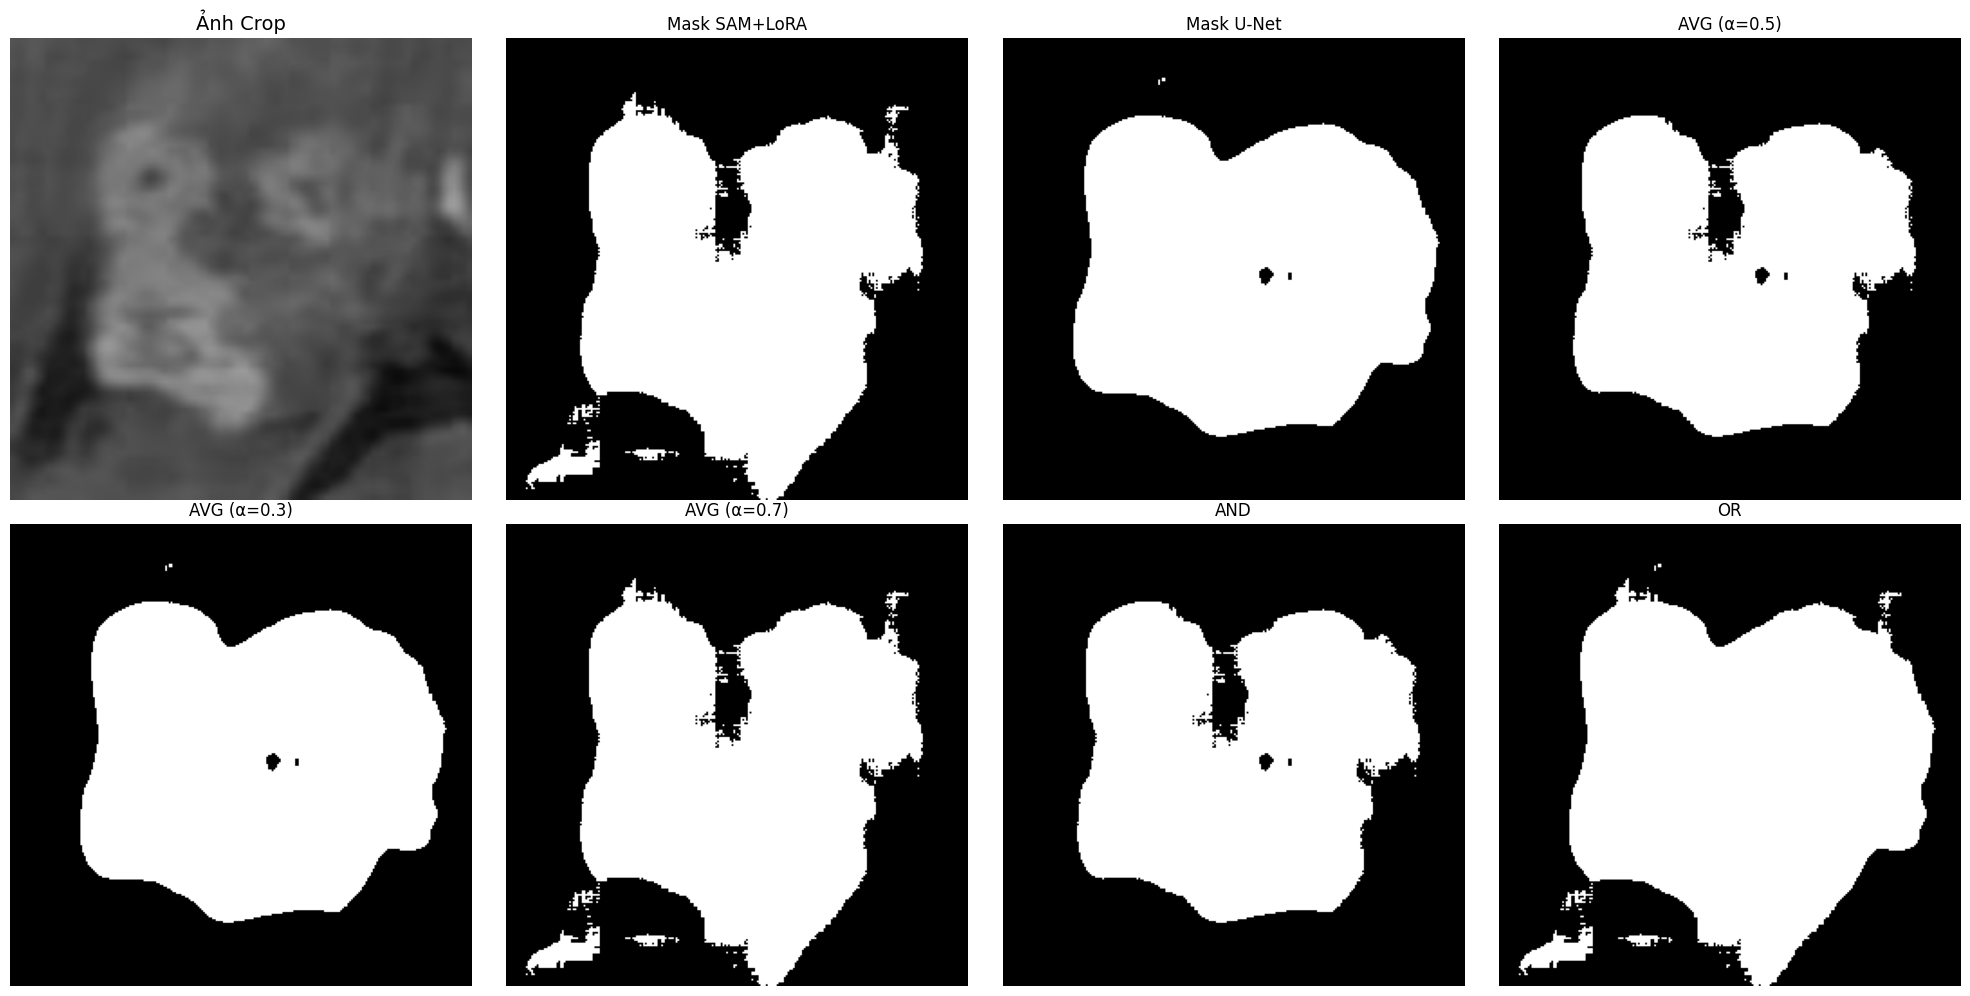

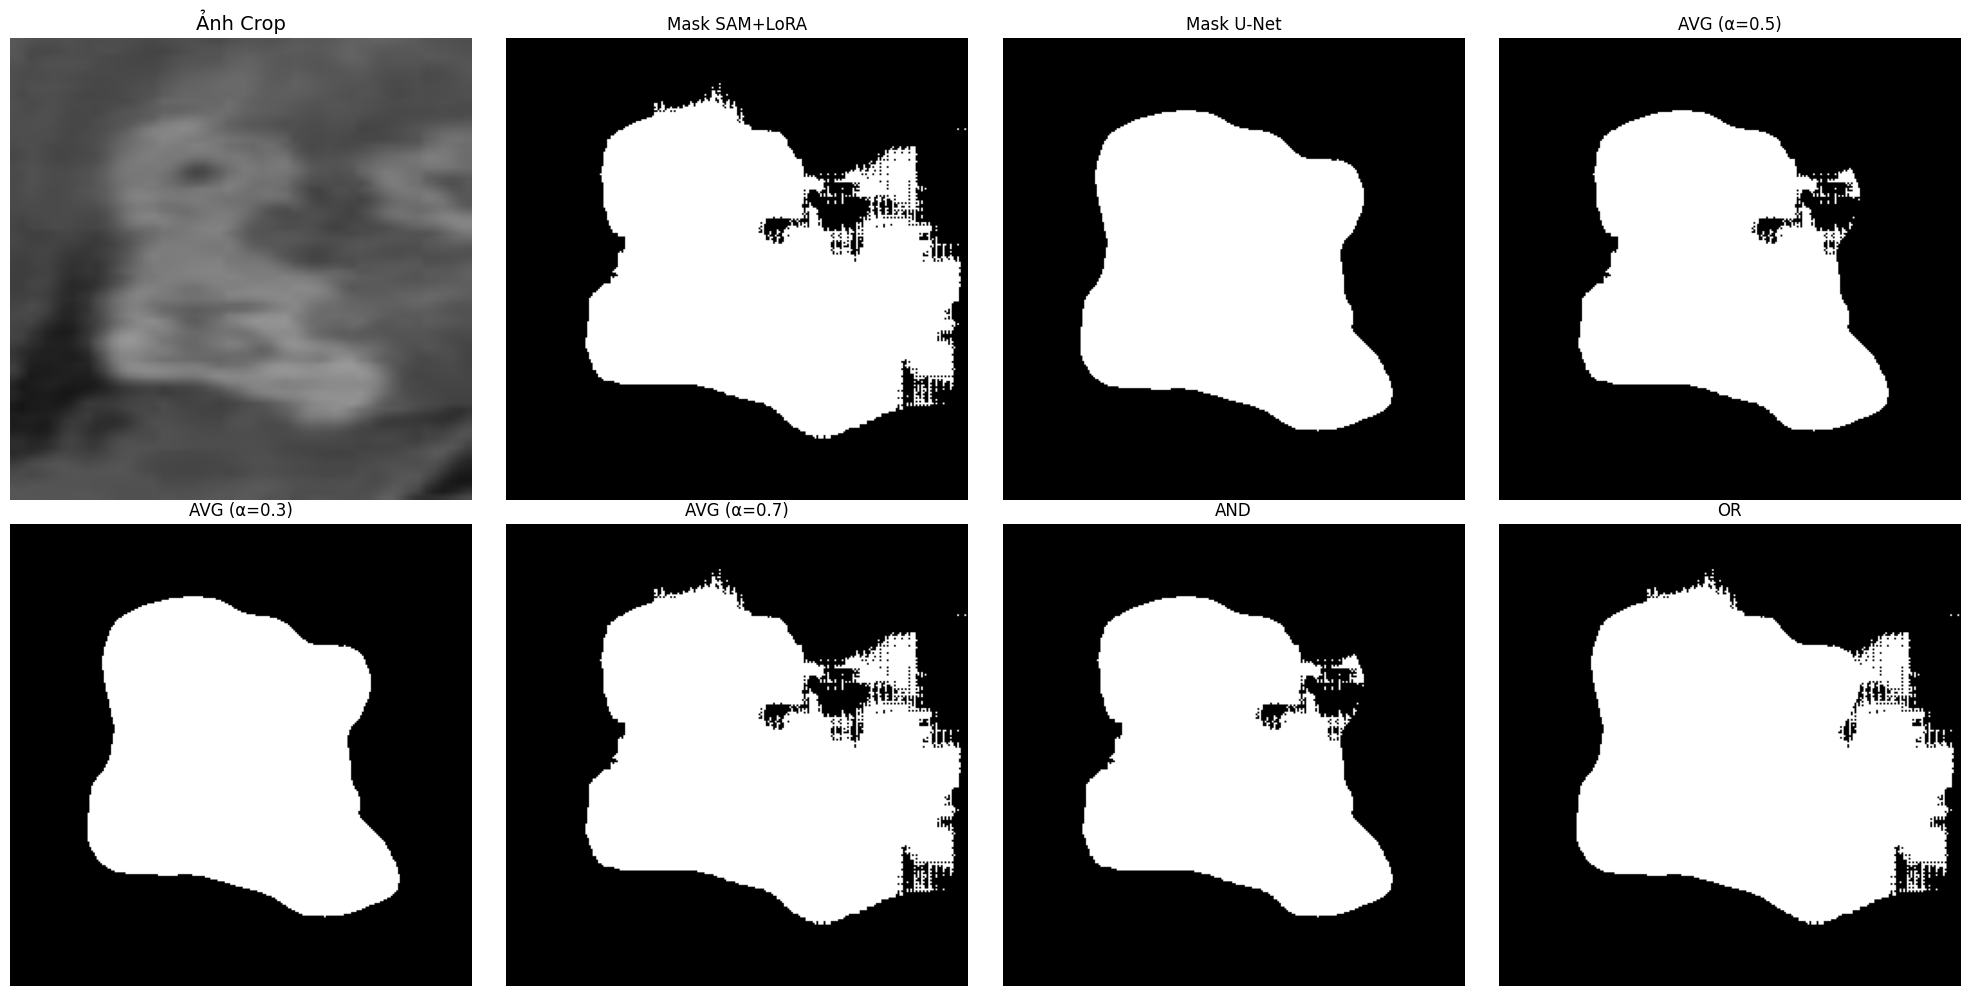

In [ ]:
run_random_image_test("/content/drive/MyDrive/Extracted_MRI/Val/Glioma/images")




0: 640x544 1 Meningioma, 17.6ms
Speed: 2.6ms preprocess, 17.6ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 544)


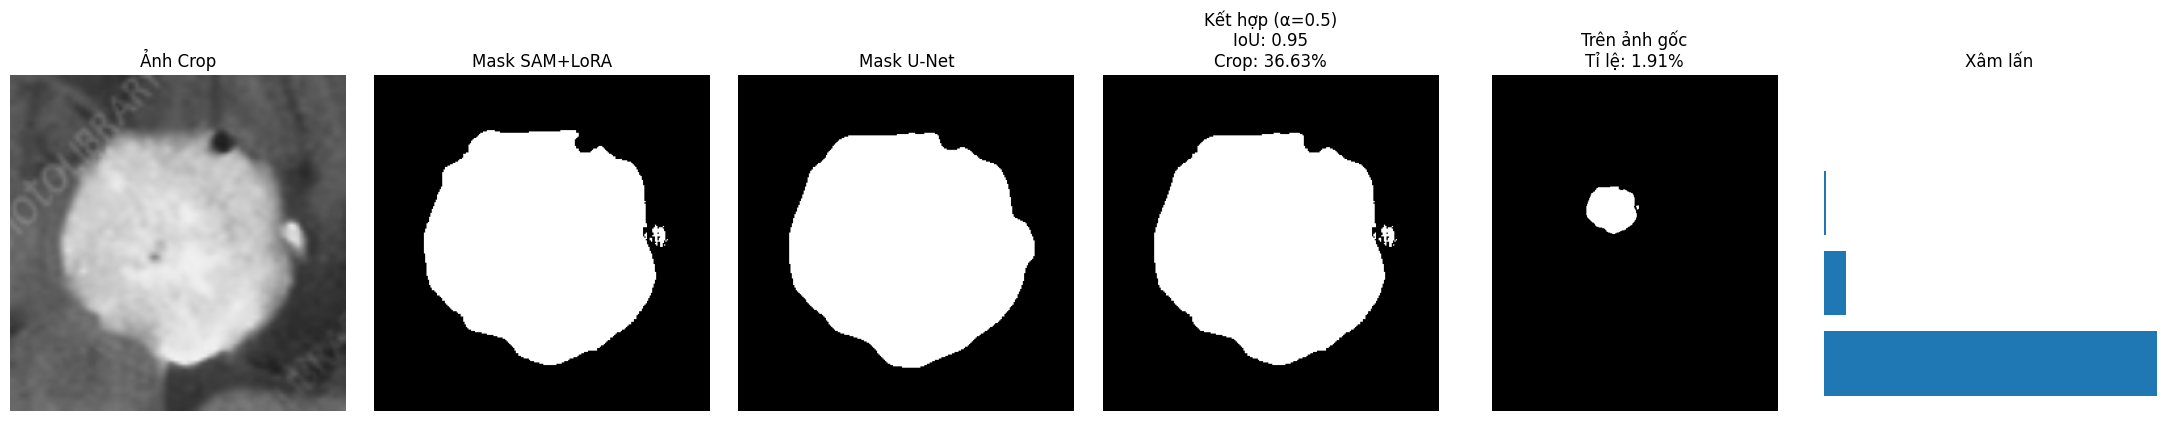

✅ Đã lưu mask tại: results_masks/mask_combined_0.png

📊 Đánh giá xâm lấn:
 - Area: 3527.0000
 - Perimeter: 230.9949
 - Compactness: 15.1286
 - Symmetry: 0.9627


In [ ]:
all_masks = full_pipeline("/content/tumor_test6.png", alpha=0.5)


In [ ]:
import os
import gc
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
from segment_anything import SamPredictor
from ultralytics import YOLO
from skimage.measure import label, regionprops
from scipy.ndimage import center_of_mass

# ==== Hàm crop ảnh từ YOLO ====
def crop_tumor_from_yolo(image_path, expand_ratio=0.2):
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    H, W = image.shape[:2]
    results = yolo_model.predict(image)[0]
    crops, bboxes = [], []

    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        w, h = x2 - x1, y2 - y1
        dw, dh = int(w * expand_ratio), int(h * expand_ratio)
        x1_new = max(x1 - dw, 0)
        y1_new = max(y1 - dh, 0)
        x2_new = min(x2 + dw, W)
        y2_new = min(y2 + dh, H)
        crop = image[y1_new:y2_new, x1_new:x2_new]
        crops.append(crop)
        bboxes.append((x1_new, y1_new, x2_new, y2_new))

    return crops, bboxes, results, image

# ==== Dự đoán mask bằng SAM ====
def predict_mask_sam(image_np, model):
    predictor = SamPredictor(model)
    predictor.set_image(image_np.astype(np.uint8))
    input_box = np.array([0, 0, image_np.shape[1], image_np.shape[0]])
    masks, _, _ = predictor.predict(box=input_box[None, :], multimask_output=False)
    return masks[0].astype(np.uint8)

# ==== Dự đoán mask từ UNet ====
def predict_mask_unet(image_pil):
    transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor()
    ])
    input_tensor = transform(image_pil).unsqueeze(0).to(DEVICE)
    with torch.inference_mode():
        output = unet(input_tensor)
    mask = output.squeeze().cpu().numpy()
    return (mask > 0.5).astype(np.uint8)

# ==== Kết hợp mask ====
def combine_masks(mask1, mask2, alpha=0.5):
    return ((alpha * mask1 + (1 - alpha) * mask2) > 0.5).astype(np.uint8)

# ==== Tỉ lệ pixel khối u ====
def tumor_pixel_ratio(mask):
    return np.sum(mask > 0) / mask.size

# ==== IoU giữa hai mask ====
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / (union + 1e-6)

# ==== Đánh giá mức độ xâm lấn ====
def analyze_invasion(mask):
    labeled_mask = label(mask)
    props = regionprops(labeled_mask)

    if not props:
        return {"Area": 0, "Perimeter": 0, "Compactness": 0, "Symmetry": 0}

    prop = max(props, key=lambda x: x.area)
    area = prop.area
    perimeter = prop.perimeter
    compactness = (perimeter ** 2) / (area + 1e-6)

    cy, cx = center_of_mass(mask)
    h, w = mask.shape
    flipped = np.flip(mask, axis=1)
    symmetry = np.sum(mask == flipped) / mask.size

    return {
        "Area": area,
        "Perimeter": perimeter,
        "Compactness": compactness,
        "Symmetry": symmetry
    }

# ==== Đánh giá từng chỉ số ====
def evaluate_metric(metric, value):
    if metric == "Compactness":
        if value < 20:
            return "OK", "Khối u có hình tròn đều"
        else:
            return "NG", "Khối u biến dạng, có thể lan rộng"
    elif metric == "Symmetry":
        if value > 0.9:
            return "OK", "Đối xứng giữa 2 bán cầu cao"
        else:
            return "NG", "Khối u không đối xứng, có thể xâm lấn lệch"
    elif metric == "Area":
        if value < 2000:
            return "OK", "Diện tích khối u nhỏ"
        else:
            return "NG", "Diện tích lớn, nên theo dõi thêm"
    elif metric == "Perimeter":
        if value < 250:
            return "OK", "Chu vi hợp lý"
        else:
            return "NG", "Chu vi lớn, có thể biên không đều"
    return "?", "Không rõ"

# ==== Pipeline tổng hợp ====
def full_pipeline(image_path, alpha=0.5, expand_ratio=0.2, save_dir="results_masks"):
    os.makedirs(save_dir, exist_ok=True)
    crops, bboxes, results, original_image = crop_tumor_from_yolo(image_path, expand_ratio)

    if not crops:
        print(f"❌ Không phát hiện khối u trong ảnh: {image_path}")
        return []

    all_masks = []

    for i, (crop, (x1, y1, x2, y2)) in enumerate(zip(crops, bboxes)):
        crop_resized = cv2.resize(crop, (256, 256), interpolation=cv2.INTER_LINEAR)
        crop_pil = Image.fromarray(crop_resized)
        crop_np = np.array(crop_pil)

        mask_sam = predict_mask_sam(crop_np, sam_lora)
        mask_unet = predict_mask_unet(crop_pil)
        mask_combined = combine_masks(mask_sam, mask_unet, alpha=alpha)

        # Resize mask về kích thước ảnh gốc
        mask_orig_size = cv2.resize(mask_combined, (x2 - x1, y2 - y1), interpolation=cv2.INTER_NEAREST)
        full_mask = np.zeros(original_image.shape[:2], dtype=np.uint8)
        full_mask[y1:y2, x1:x2] = mask_orig_size
        all_masks.append(full_mask)

        # Tính toán thống kê
        ratio_crop = tumor_pixel_ratio(mask_combined)
        ratio_full = tumor_pixel_ratio(full_mask)
        iou = compute_iou(mask_sam, mask_unet)
        invasion_metrics = analyze_invasion(full_mask)

        # Việt hóa tên chỉ số
        label_map = {
            "Area": "Diện tích",
            "Perimeter": "Chu vi",
            "Compactness": "Độ tròn",
            "Symmetry": "Đối xứng"
        }

        # Hiển thị
        fig, axs = plt.subplots(1, 5, figsize=(20, 4))
        axs[0].imshow(crop_pil)
        axs[0].set_title("Ảnh Crop")
        axs[1].imshow(mask_sam, cmap="gray")
        axs[1].set_title("Mask SAM+LoRA")
        axs[2].imshow(mask_unet, cmap="gray")
        axs[2].set_title("Mask U-Net")
        axs[3].imshow(mask_combined, cmap="gray")
        axs[3].set_title(f"Kết hợp (α={alpha})\nIoU: {iou:.2f}\nCrop: {ratio_crop:.2%}")
        axs[4].imshow(full_mask, cmap="gray")
        axs[4].set_title(f"Trên ảnh gốc\nTỉ lệ: {ratio_full:.2%}")

        for ax in axs:
            ax.axis("off")

        plt.tight_layout()
        plt.show()

        # In dòng chỉ số xâm lấn và đánh giá
        print("=== Đánh giá xâm lấn ===")
        for key, value in invasion_metrics.items():
            name = label_map.get(key, key)
            status, explain = evaluate_metric(key, value)
            print(f"{name}: {value:.2f} → {status} ({explain})")
        print("========================\n")

    return all_masks


In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
from segment_anything import SamPredictor
from ultralytics import YOLO
from skimage.measure import label, regionprops
from scipy.ndimage import center_of_mass

# ==== Hàm crop ảnh từ YOLO ====
def crop_tumor_from_yolo(image_path, expand_ratio=0.2):
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    H, W = image.shape[:2]
    results = yolo_model.predict(image)[0]
    crops, bboxes = [], []

    for box in results.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        w, h = x2 - x1, y2 - y1
        dw, dh = int(w * expand_ratio), int(h * expand_ratio)
        x1_new = max(x1 - dw, 0)
        y1_new = max(y1 - dh, 0)
        x2_new = min(x2 + dw, W)
        y2_new = min(y2 + dh, H)
        crop = image[y1_new:y2_new, x1_new:x2_new]
        crops.append(crop)
        bboxes.append((x1_new, y1_new, x2_new, y2_new))

    return crops, bboxes, results, image

# ==== Dự đoán mask ====
def predict_mask_sam(image_np, model):
    predictor = SamPredictor(model)
    predictor.set_image(image_np.astype(np.uint8))
    input_box = np.array([0, 0, image_np.shape[1], image_np.shape[0]])
    masks, _, _ = predictor.predict(box=input_box[None, :], multimask_output=False)
    return masks[0].astype(np.uint8)

def predict_mask_unet(image_pil):
    transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor()
    ])
    input_tensor = transform(image_pil).unsqueeze(0).to(DEVICE)
    with torch.inference_mode():
        output = unet(input_tensor)
    mask = output.squeeze().cpu().numpy()
    return (mask > 0.5).astype(np.uint8)

# ==== Đánh giá và kết hợp ====
def combine_masks(mask1, mask2, alpha=0.5):
    return ((alpha * mask1 + (1 - alpha) * mask2) > 0.5).astype(np.uint8)

def tumor_pixel_ratio(mask):
    return np.sum(mask > 0) / mask.size

def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return intersection / (union + 1e-6)

def analyze_invasion(mask):
    labeled_mask = label(mask)
    props = regionprops(labeled_mask)
    if not props:
        return {"Area": 0, "Perimeter": 0, "Compactness": 0, "Symmetry": 0}
    prop = max(props, key=lambda x: x.area)
    area = prop.area
    perimeter = prop.perimeter
    compactness = (perimeter ** 2) / (area + 1e-6)
    flipped = np.flip(mask, axis=1)
    symmetry = np.sum(mask == flipped) / mask.size
    return {
        "Area": area,
        "Perimeter": perimeter,
        "Compactness": compactness,
        "Symmetry": symmetry
    }

def evaluate_metric(metric, value):
    if metric == "Compactness":
        return ("OK", "Khối u có hình tròn đều") if value < 20 else ("NG", "Khối u biến dạng, có thể lan rộng")
    elif metric == "Symmetry":
        return ("OK", "Đối xứng giữa 2 bán cầu cao") if value > 0.9 else ("NG", "Không đối xứng, có thể xâm lấn lệch")
    elif metric == "Area":
        return ("OK", "Diện tích nhỏ") if value < 2000 else ("NG", "Diện tích lớn, nên theo dõi")
    elif metric == "Perimeter":
        return ("OK", "Chu vi hợp lý") if value < 250 else ("NG", "Chu vi lớn, biên không đều")
    return "?", "Không rõ"

# ==== Hàm hiển thị từng bước ====
def visualize_pipeline_steps(original_image, image_copy, crop_pil, mask_sam, mask_unet, mask_combined,
                             iou, ratio_full, invasion_metrics, tumor_label="Unknown", save_path=None):
    fig, axs = plt.subplots(2, 3, figsize=(18, 8))
    axs = axs.flatten()

    axs[0].imshow(original_image)
    axs[0].set_title(f"Ảnh gốc\nLoại: {tumor_label}", fontsize=12)

    axs[1].imshow(image_copy)
    axs[1].set_title("YOLO + Bounding Box", fontsize=12)

    axs[2].imshow(crop_pil)
    axs[2].set_title("Ảnh Crop", fontsize=12)

    axs[3].imshow(mask_sam, cmap="gray")
    axs[3].set_title("Mask SAM+LoRA", fontsize=12)

    axs[4].imshow(mask_unet, cmap="gray")
    axs[4].set_title("Mask U-Net", fontsize=12)

    axs[5].imshow(mask_combined, cmap="gray")
    eval_text = (
        f"Kết hợp\nIoU: {iou:.2f}\nTỉ lệ: {ratio_full:.1%}\n"
        f"A: {invasion_metrics['Area']:.0f}, P: {invasion_metrics['Perimeter']:.0f}\n"
        f"C: {invasion_metrics['Compactness']:.1f}, S: {invasion_metrics['Symmetry']:.2f}"
    )
    axs[5].set_title(eval_text, fontsize=12)

    for ax in axs:
        ax.axis("off")

    plt.suptitle(f"⚠️ Loại khối u: {tumor_label}", fontsize=20, color='darkred', weight='bold', y=1.05)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# ==== Pipeline tổng hợp ====
def full_pipeline(image_path, alpha=0.5, expand_ratio=0.2, save_dir="results_masks"):
    os.makedirs(save_dir, exist_ok=True)
    crops, bboxes, results, original_image = crop_tumor_from_yolo(image_path, expand_ratio)

    if not crops:
        print(f"❌ Không phát hiện khối u trong ảnh: {image_path}")
        return []

    all_masks = []

    for i, (crop, (x1, y1, x2, y2), box) in enumerate(zip(crops, bboxes, results.boxes)):
        crop_resized = cv2.resize(crop, (256, 256), interpolation=cv2.INTER_LINEAR)
        crop_pil = Image.fromarray(crop_resized)
        crop_np = np.array(crop_pil)

        mask_sam = predict_mask_sam(crop_np, sam_lora)
        mask_unet = predict_mask_unet(crop_pil)
        mask_combined = combine_masks(mask_sam, mask_unet, alpha=alpha)

        # Resize mask về ảnh gốc
        mask_orig_size = cv2.resize(mask_combined, (x2 - x1, y2 - y1), interpolation=cv2.INTER_NEAREST)
        full_mask = np.zeros(original_image.shape[:2], dtype=np.uint8)
        full_mask[y1:y2, x1:x2] = mask_orig_size
        all_masks.append(full_mask)

        # Thống kê
        ratio_full = tumor_pixel_ratio(full_mask)
        iou = compute_iou(mask_sam, mask_unet)
        invasion_metrics = analyze_invasion(full_mask)

        # Vẽ bounding box + nhãn
        image_copy = original_image.copy()
        x1_box, y1_box, x2_box, y2_box = map(int, box.xyxy[0])
        conf = float(box.conf[0])
        cls_id = int(box.cls[0].item())
        tumor_label = yolo_model.names[cls_id]
        label_text = f"{tumor_label} ({conf:.2f})"
        cv2.rectangle(image_copy, (x1_box, y1_box), (x2_box, y2_box), (255, 0, 0), 2)
        cv2.putText(image_copy, label_text, (x1_box, y1_box - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

        # Hiển thị và lưu hình minh họa
        save_path = os.path.join(save_dir, f"pipeline_step_{i}.png")
        visualize_pipeline_steps(
            original_image=original_image,
            image_copy=image_copy,
            crop_pil=crop_pil,
            mask_sam=mask_sam,
            mask_unet=mask_unet,
            mask_combined=mask_combined,
            iou=iou,
            ratio_full=ratio_full,
            invasion_metrics=invasion_metrics,
            tumor_label=tumor_label,
            save_path=save_path
        )

        # In đánh giá
        print("=== Đánh giá xâm lấn ===")
        label_map = {
            "Area": "Diện tích",
            "Perimeter": "Chu vi",
            "Compactness": "Độ tròn",
            "Symmetry": "Đối xứng"
        }
        for key, value in invasion_metrics.items():
            name = label_map.get(key, key)
            status, explain = evaluate_metric(key, value)
            print(f"{name}: {value:.2f} → {status} ({explain})")
        print("========================\n")

    return all_masks



0: 640x544 1 Meningioma, 16.0ms
Speed: 2.7ms preprocess, 16.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


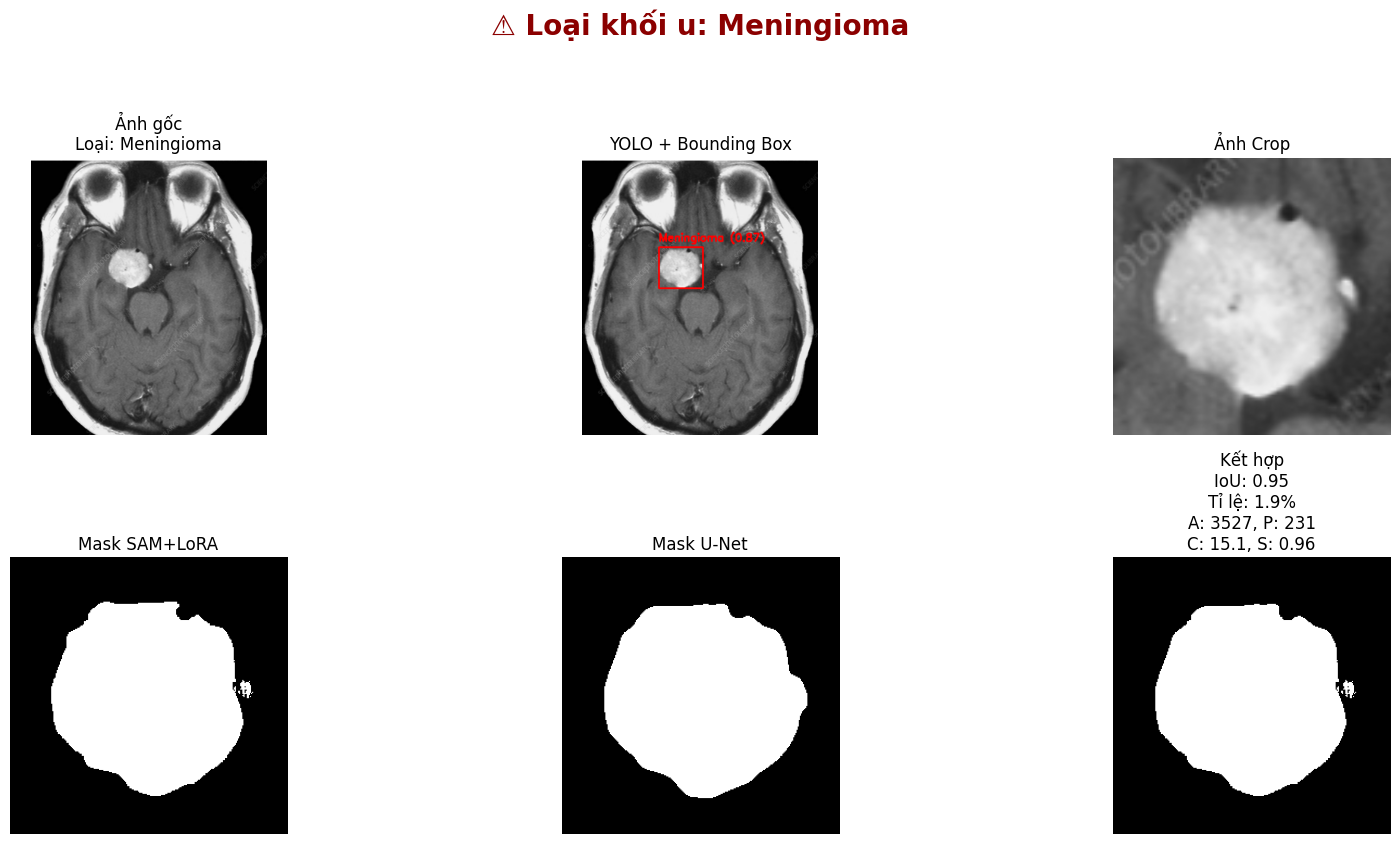

=== Đánh giá xâm lấn ===
Diện tích: 3527.00 → NG (Diện tích lớn, nên theo dõi)
Chu vi: 230.99 → OK (Chu vi hợp lý)
Độ tròn: 15.13 → OK (Khối u có hình tròn đều)
Đối xứng: 0.96 → OK (Đối xứng giữa 2 bán cầu cao)



In [ ]:
all_masks = full_pipeline("/content/tumor_test6.png", alpha=0.5)


0: 640x608 1 Meningioma, 17.8ms
Speed: 3.0ms preprocess, 17.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 608)


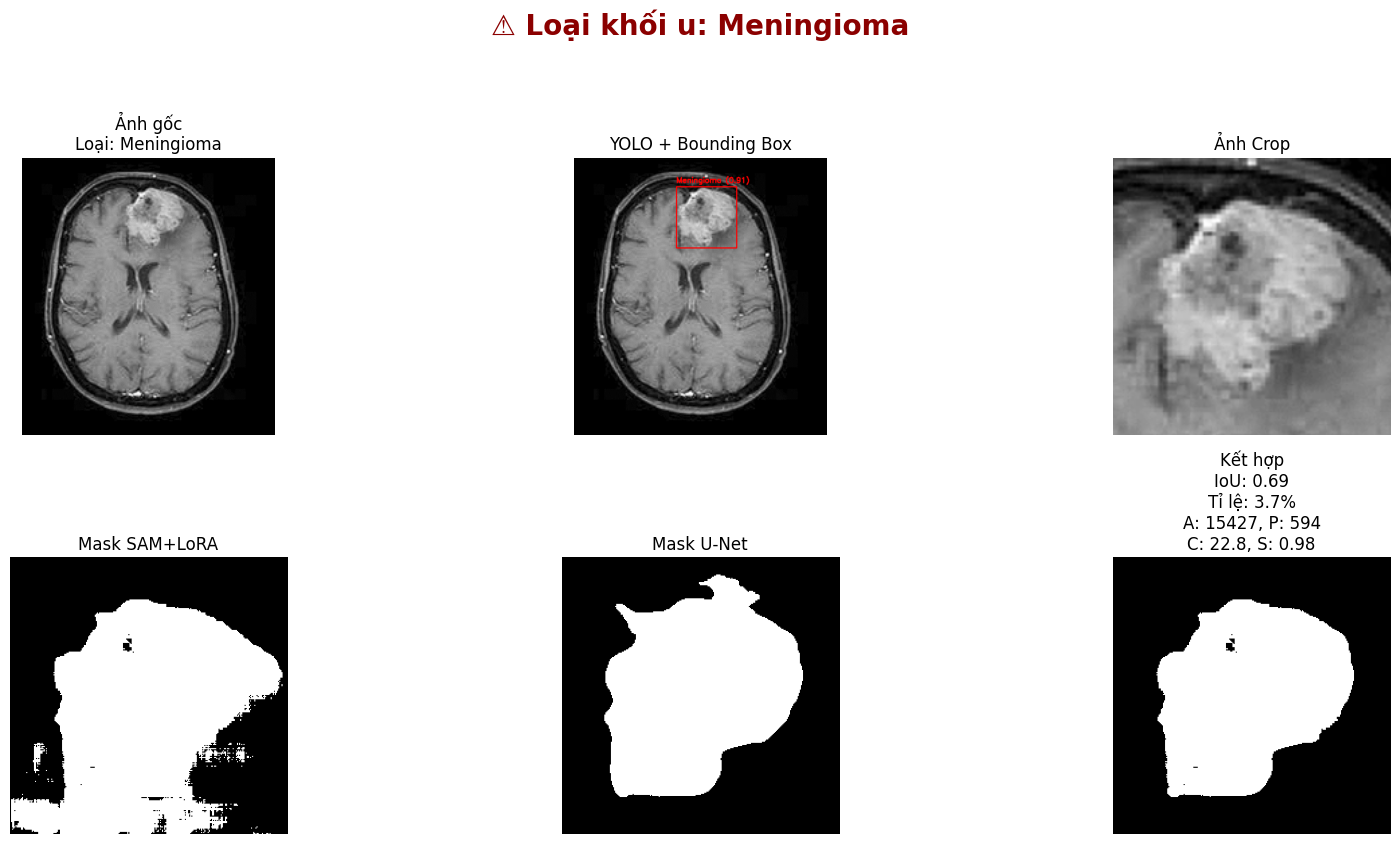

=== Đánh giá xâm lấn ===
Diện tích: 15427.00 → NG (Diện tích lớn, nên theo dõi)
Chu vi: 593.62 → NG (Chu vi lớn, biên không đều)
Độ tròn: 22.84 → NG (Khối u biến dạng, có thể lan rộng)
Đối xứng: 0.98 → OK (Đối xứng giữa 2 bán cầu cao)



In [ ]:
all_masks = full_pipeline("/content/tumor_test.png", alpha=0.5)


0: 640x544 1 Meningioma, 17.5ms
Speed: 2.6ms preprocess, 17.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


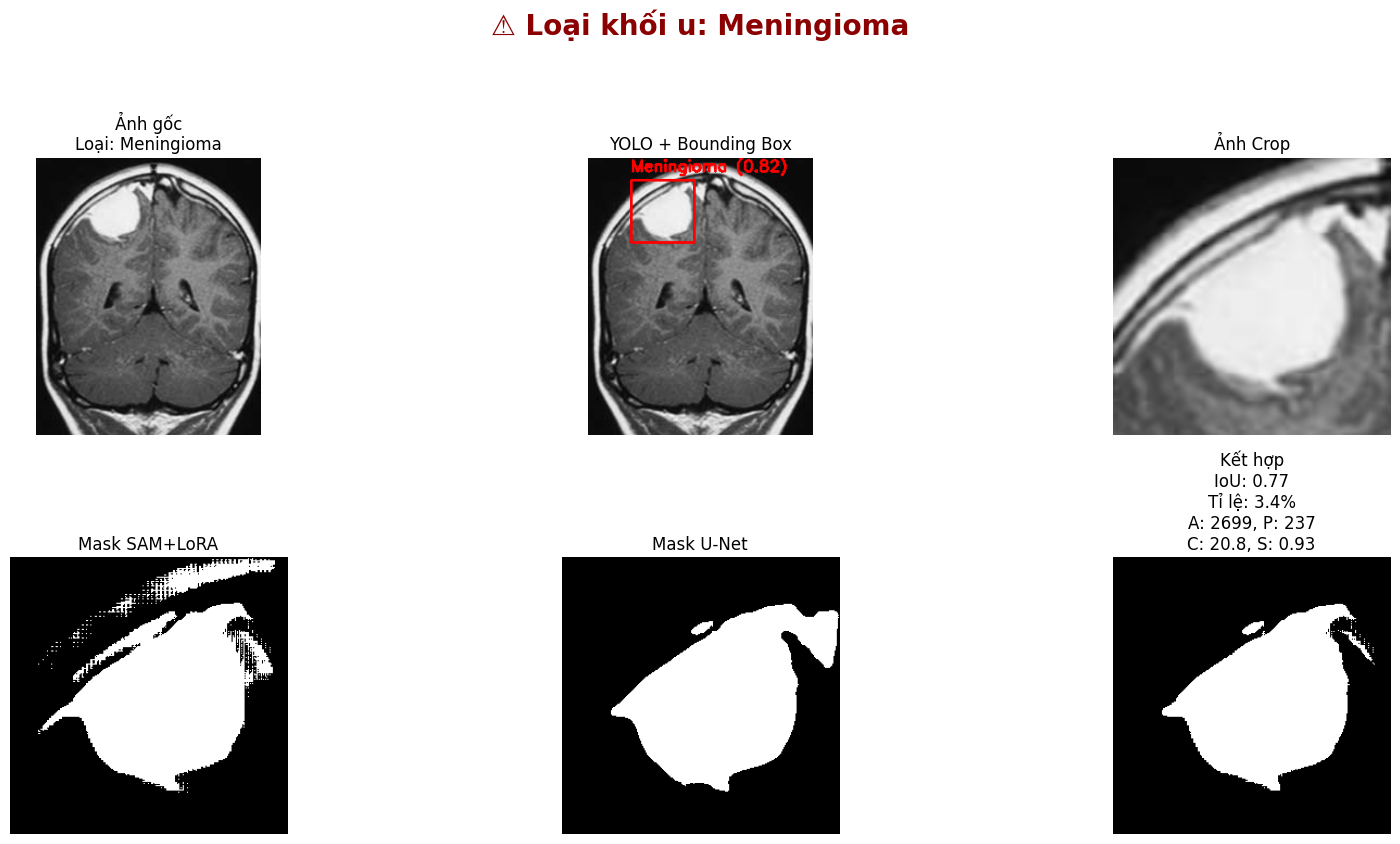

=== Đánh giá xâm lấn ===
Diện tích: 2699.00 → NG (Diện tích lớn, nên theo dõi)
Chu vi: 237.04 → OK (Chu vi hợp lý)
Độ tròn: 20.82 → NG (Khối u biến dạng, có thể lan rộng)
Đối xứng: 0.93 → OK (Đối xứng giữa 2 bán cầu cao)



In [ ]:
all_masks = full_pipeline("/content/tumor_test10.png", alpha=0.5)

In [ ]:
all_masks = full_pipeline("/content/tumor_test9.png", alpha=0.5)


0: 640x576 (no detections), 16.0ms
Speed: 2.7ms preprocess, 16.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)
❌ Không phát hiện khối u trong ảnh: /content/tumor_test9.png



0: 640x576 1 Pituitary, 17.6ms
Speed: 3.1ms preprocess, 17.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 576)


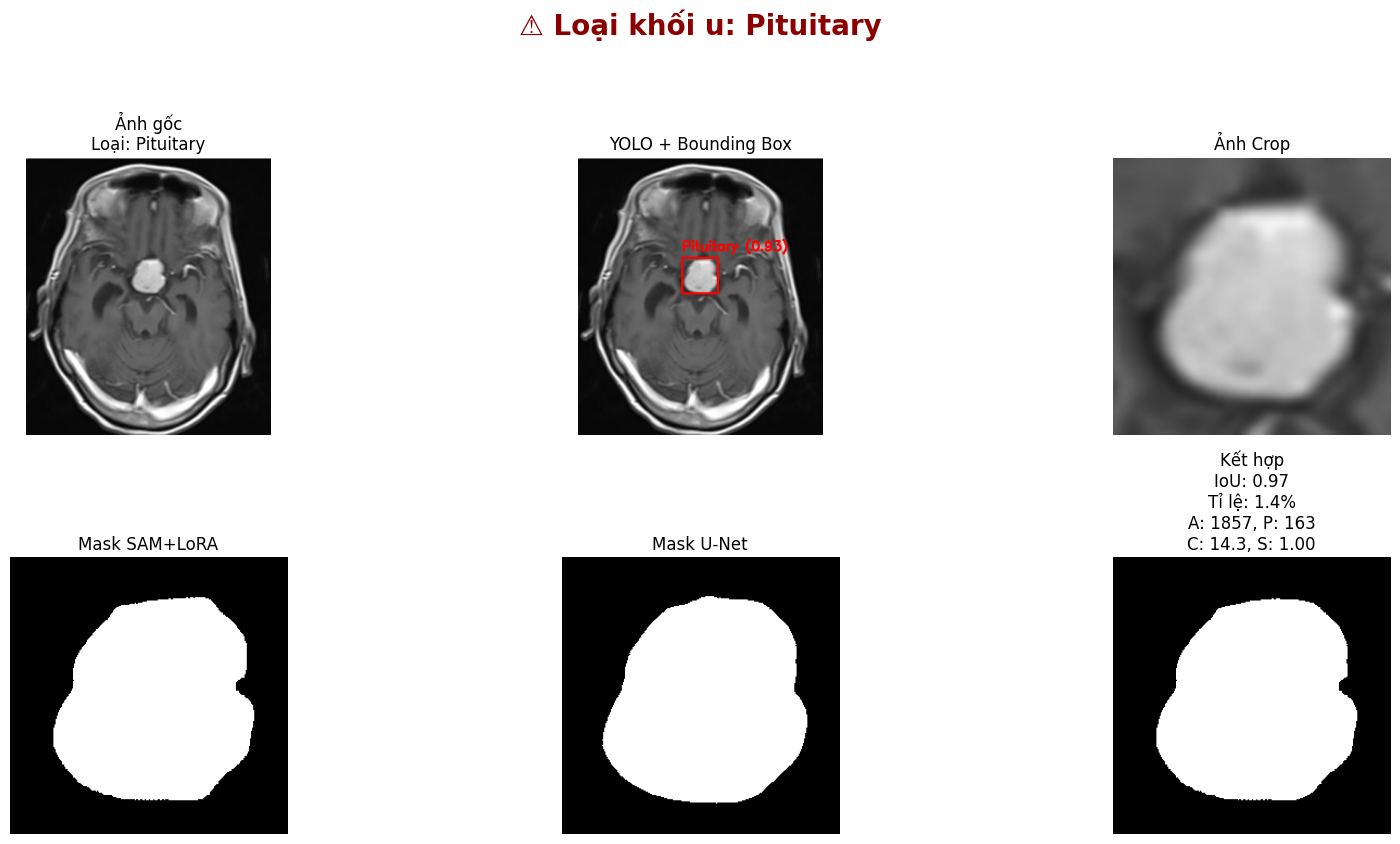

=== Đánh giá xâm lấn ===
Diện tích: 1857.00 → OK (Diện tích nhỏ)
Chu vi: 162.71 → OK (Chu vi hợp lý)
Độ tròn: 14.26 → OK (Khối u có hình tròn đều)
Đối xứng: 1.00 → OK (Đối xứng giữa 2 bán cầu cao)



In [ ]:
all_masks = full_pipeline("/content/tumor_test8.png", alpha=0.5)


0: 640x640 2 Meningiomas, 18.0ms
Speed: 2.9ms preprocess, 18.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


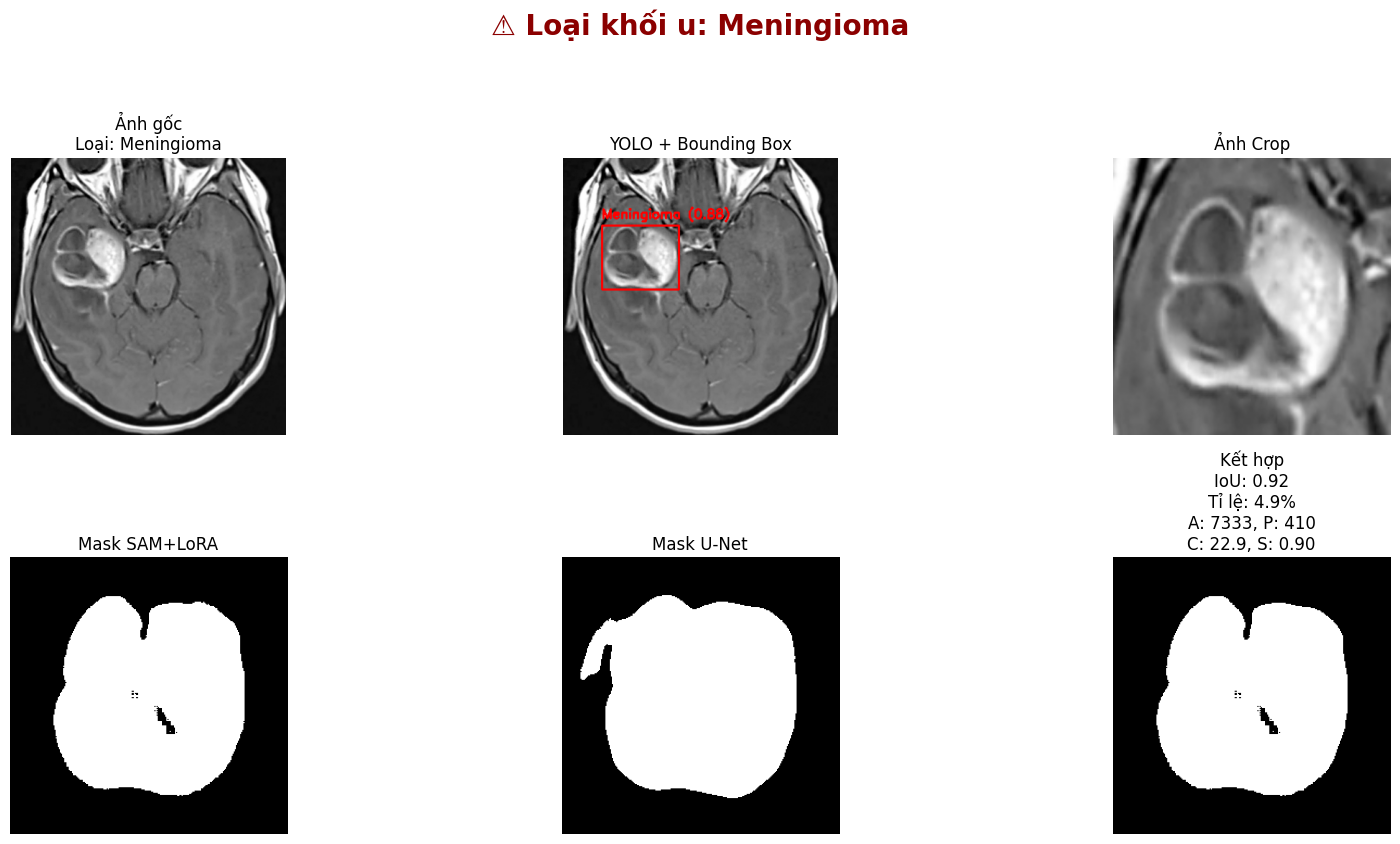

=== Đánh giá xâm lấn ===
Diện tích: 7333.00 → NG (Diện tích lớn, nên theo dõi)
Chu vi: 409.71 → NG (Chu vi lớn, biên không đều)
Độ tròn: 22.89 → NG (Khối u biến dạng, có thể lan rộng)
Đối xứng: 0.90 → OK (Đối xứng giữa 2 bán cầu cao)



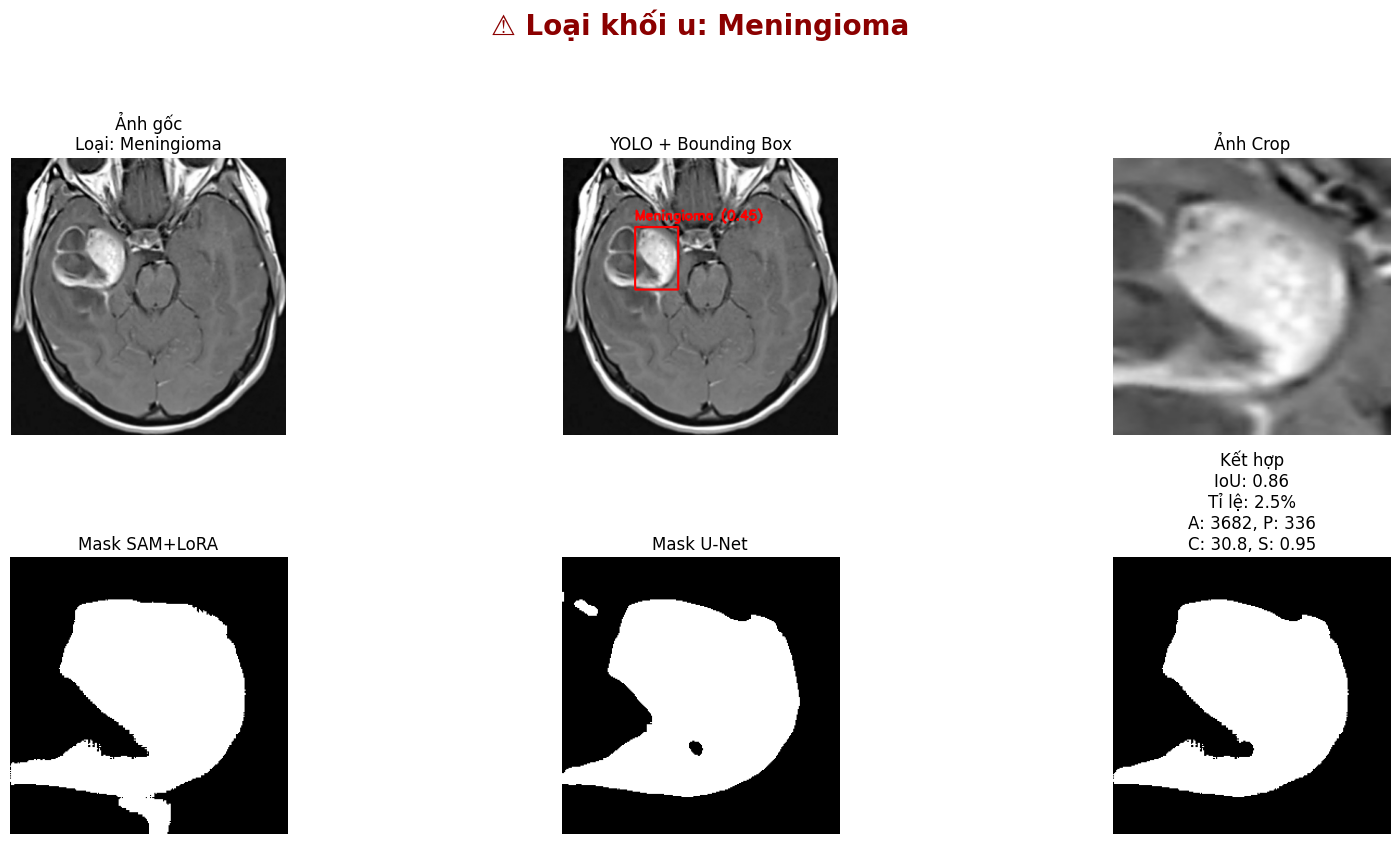

=== Đánh giá xâm lấn ===
Diện tích: 3682.00 → NG (Diện tích lớn, nên theo dõi)
Chu vi: 336.49 → NG (Chu vi lớn, biên không đều)
Độ tròn: 30.75 → NG (Khối u biến dạng, có thể lan rộng)
Đối xứng: 0.95 → OK (Đối xứng giữa 2 bán cầu cao)



In [ ]:
all_masks = full_pipeline("/content/tumor_test4.png", alpha=0.5)


0: 640x544 1 Meningioma, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


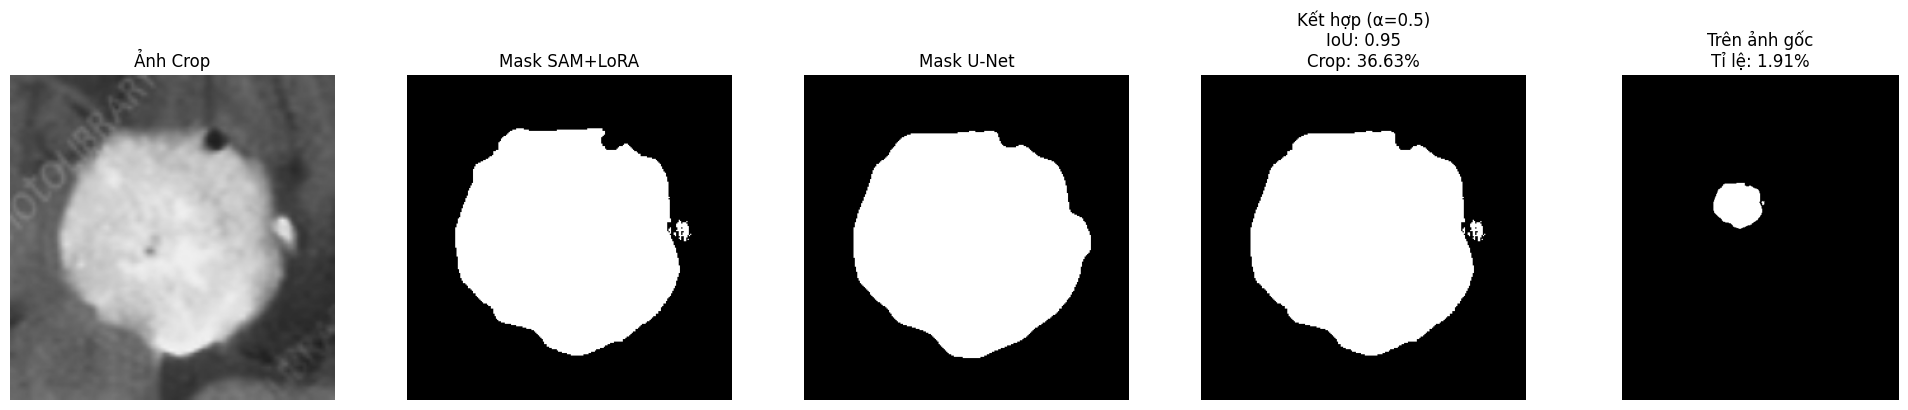

=== Đánh giá xâm lấn ===
Diện tích: 3527.00 → NG (Diện tích lớn, nên theo dõi thêm)
Chu vi: 230.99 → OK (Chu vi hợp lý)
Độ tròn: 15.13 → OK (Khối u có hình tròn đều)
Đối xứng: 0.96 → OK (Đối xứng giữa 2 bán cầu cao)



In [ ]:
all_masks = full_pipeline("/content/tumor_test6.png", alpha=0.5)


0: 640x608 1 No Tumor, 16.9ms
Speed: 2.8ms preprocess, 16.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)


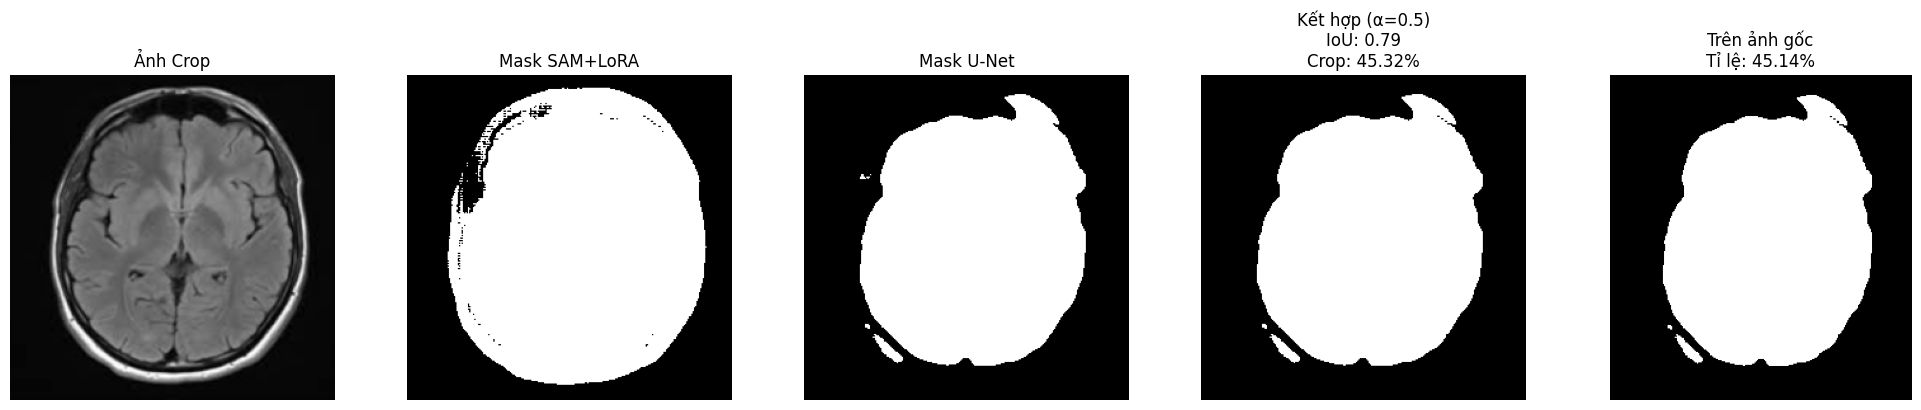

=== Đánh giá xâm lấn ===
Diện tích: 31919.00 → NG (Diện tích lớn, nên theo dõi thêm)
Chu vi: 774.93 → NG (Chu vi lớn, có thể biên không đều)
Độ tròn: 18.81 → OK (Khối u có hình tròn đều)
Đối xứng: 0.89 → NG (Khối u không đối xứng, có thể xâm lấn lệch)



In [ ]:
all_masks = full_pipeline("/content/tumor_test7.png", alpha=0.5)

In [ ]:
def evaluate_on_folder(folder_path, alpha=0.5):
    image_paths = sorted([
        os.path.join(folder_path, f)
        for f in os.listdir(folder_path)
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ])

    all_ious = []
    all_ratios = []

    for image_path in image_paths:
        crops, bboxes, results, original_image = crop_tumor_from_yolo(image_path)

        if not crops:
            print(f"[SKIP] Không phát hiện khối u: {os.path.basename(image_path)}")
            continue

        for crop, (x1, y1, x2, y2) in zip(crops, bboxes):
            crop_resized = cv2.resize(crop, (256, 256), interpolation=cv2.INTER_LINEAR)
            crop_pil = Image.fromarray(crop_resized)
            crop_np = np.array(crop_pil)

            mask_sam = predict_mask_sam(crop_np, sam_lora)
            mask_unet = predict_mask_unet(crop_pil)
            mask_combined = combine_masks(mask_sam, mask_unet, alpha=alpha)

            iou = compute_iou(mask_sam, mask_unet)
            mask_combined_resized = cv2.resize(mask_combined, (x2 - x1, y2 - y1), interpolation=cv2.INTER_NEAREST)
            full_mask = np.zeros(original_image.shape[:2], dtype=np.uint8)
            full_mask[y1:y2, x1:x2] = mask_combined_resized

            tumor_ratio = tumor_pixel_ratio(full_mask)

            all_ious.append(iou)
            all_ratios.append(tumor_ratio)

    if not all_ious:
        print("❌ Không có ảnh nào có khối u được phát hiện.")
        return

    print("=== ĐÁNH GIÁ TỔNG QUAN ===")
    print(f"- Số ảnh có khối u: {len(all_ious)}")
    print(f"- IoU trung bình: {np.mean(all_ious):.4f} ± {np.std(all_ious):.4f}")
    print(f"- Tỉ lệ khối u trung bình: {np.mean(all_ratios)*100:.2f}%")
    print(f"- Tỉ lệ khối u lớn nhất: {np.max(all_ratios)*100:.2f}%")
    print(f"- Tỉ lệ khối u nhỏ nhất: {np.min(all_ratios)*100:.2f}%")
    print("===========================")


In [ ]:
evaluate_on_folder("/content/drive/MyDrive/Extracted_MRI/Train/Meningioma/images")



0: 640x640 1 Meningioma, 18.3ms
Speed: 3.7ms preprocess, 18.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Meningioma, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Meningioma, 9.1ms
Speed: 3.6ms preprocess, 9.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Meningioma, 7.5ms
Speed: 3.0ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Meningioma, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Meningioma, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Meningioma, 7.5ms
Speed: 2.7ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Meningioma, 7.6ms
Speed: 3.2ms preprocess, 7.6ms inference, 1.5ms postprocess per image 